In [1]:
import numpy as np
import pandas as pd
import datetime
import random
from time import time
import math
from scipy import sparse

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from multiprocessing import Pool
import timeit

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [2]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or innder id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        if len(lf_sp) != 3:
            raise Exception('''Bad line format!
            line_format should be space-separated and it should always specified by 
            "user item rating" with any order!''')
        user_idx = -1
        item_idx = -1
        rating_idx = -1
        timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
#             elif lf_sp[c] == 'timestamp':
#                 timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating) separated by sep!')
        
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
        
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
#         timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
#             timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
#             timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
#         self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
#             self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('Number of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests

# <font color=orange>reading the dataset & splitting it into train and test</font>

In [3]:
dataset = RatingDataset()
data_fn = 'data/Kiva/rating_5000_cls_hc_10core_iterative.csv'
dataset.read_from_file(data_fn, line_format='user item rating', sep='\t')

In [4]:
print(dataset.user_n)
print(dataset.item_n)

4005
2673


In [5]:
# train_mat: Training data sparse matrix
# user_tests: A dictionary for each user(key) stores the set of items that is positively rated(>= 4stars) by this user.

train_mat, user_tests = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)

Number of users with some items in testset: 4005
Number of ratings in trainset: 89678 	 Number of ratings in testset: 20693


In [68]:
dataset.rating_mat.shape

(4005, 2673)

# Saving the groundtruth / test set

In [7]:
# test set
u_t_list = []

for uid in user_tests.keys():
    base_rec = pd.DataFrame(user_tests[uid])
    base_rec[2] = uid
    u_t_list.append(base_rec[[2,0,1]])

u_t_df = pd.concat(u_t_list, ignore_index=True)
u_t_df.columns=['userid', 'itemid', 'rating']
u_t_df.to_csv('./RECSYS/SIGIR/test_kiva.csv', index=False, header=None)
u_t_df.head()

,userid,itemid,rating
0,0,390,3.0
1,0,2154,3.0
2,1,145,3.0
3,1,1261,3.0
4,1,1255,3.0


In [8]:
# np.save('./RECSYS/SIGIR/trainmatrix_kiva.npy', train_mat.toarray())
# sth = np.load('./RECSYS/SIGIR/trainmatrix_kiva.npy')
# print (sth.shape)

# <font color=orange>Evaluation</font>

## Performance metrics: 
- nDCG_Time, 
- nDCG, 
- Recall and 
- Precision

In [9]:
import math

# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) #topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


"""the difference between this function and above is their relevance score. Here we use rating and above we use ranking.
The ground truth here is different. It is basically the dataframe with ratings not only a list of items."""
def nDCG(groundTruth, _recList):
    
    rec_num = len(_recList) #topK
    idealOrder = groundTruth.sort_values(by='rating', ascending=False)['itemid']

    idealDCG = 0.0
    for j in range(rec_num):
        sc = 0
        if j < len(idealOrder):
    #         sc = idealOrder[j][1]
            sc = groundTruth.loc[idealOrder.index[j], 'rating']
        if sc < 0:
            sc = 0

        idealDCG += (math.pow(2.0, sc) - 1.0) / (math.log(2.0 + j))
#         idealDCG += (sc) / (math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
    #         if item in ground_truth.keys():
        if item in groundTruth.itemid.tolist():
    #         sc = ground_truth[item]
            sc = groundTruth.loc[groundTruth['itemid'] == item, 'rating'].values[0]
        else:
            sc = 0

        recDCG += (math.pow(2.0, sc) - 1.0) / (math.log(2 + j))
#         recDCG += (sc) / (math.log(2 + j))

    return (recDCG / idealDCG)



def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))


## Beyond accuracy metrics: 
- Intra-List Diversity, and 
- feature-based Entropy

In [10]:
# Intra List Distance
def ILD(_recList):
    
    # convert inner ids to imdbids
    _recList_if_ids = [InnerID_to_iiMatrixID[Inner_ID] for Inner_ID in _recList]
    _recList_if_ids = list(map(int, _recList))
  
    totalDisSimilarityPerUser = 0
    topK =  len(_recList)
    
    for item_i in _recList_if_ids:
        for item_j in _recList_if_ids:
             if (item_i != item_j):
                # this vector (i) and that vector (j)
                totalDisSimilarityPerUser += (1.0 - itemItemSimilarityByFeature[item_i, item_j])
    
    diversityPerUser = (totalDisSimilarityPerUser * 2.0) / (topK * (topK - 1.0))
    return (diversityPerUser)    



def ENTROPY_(_recList):
    
    # given a user id, it calcualtes the entropy for the recommendation list of a user
    _recList_ids = list(map(int, _recList))
    feature_count_vector = item_features_df[item_features_df.index.isin(_recList_ids)].sum(axis=0)
    
    # turn it back to a list of labels so we can pass it to entropy_()
    # _recList_item_features = [i for i in feature_count_vector[feature_count_vector != 0].index for j in range(feature_count_vector[i])]
    _recList_item_features = [i for i in feature_count_vector[feature_count_vector != 0].index]

    # send the labels to the entropy_() to calculate the netropy over all the labels combined.
    return entropy_(_recList_item_features)

    
def entropy_(labels, base=None):
    from math import log, e
    """ Computes entropy of label distribution. """

    n_labels = len(labels)
    if n_labels <= 1:
        return 0

    value, counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    
    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

# the evaluation function

In [11]:

def myEvaluations(u, groundTruth, recs):

    recall = precision = ndcg = ndcg_t = diversity_ild = diversity_entropy = 0.0
    if len(groundTruth[groundTruth['userid'] == u]) > 0:
        
        # Only considering the items that user has rated high (>=4), these predictions matter most.
        test_items = groundTruth.loc[(groundTruth['userid'] == u) & (groundTruth['rating'] >= 4), 'itemid'].tolist()

        if len(test_items) > 0:
            # top items
            top_items = recs.loc[recs['userid'] == u, 'itemid'].tolist()[:10]
            
            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)
            ndcg_t = nDCG_Time(test_items, top_items)
            # we need to also pass the ratings, so I pass the whole dataframe for the user here instead of test_items.
            ndcg = nDCG(groundTruth.loc[(groundTruth['userid'] == u) & (groundTruth['rating'] >= 4)], top_items)

            # only top_items or recommendation list is needed for diversity and fairness
            diversity_ild = ILD(top_items)
            diversity_entropy = ENTROPY_(top_items)
        
    return (recall, precision, ndcg, ndcg_t, diversity_ild, diversity_entropy)


# <font color=orange>Reading item-feature matrix </font>

In [12]:

item_features_df = pd.read_csv('./data/Kiva/loan_feature_matrix_hc_10core.csv', dtype=int)
item_features_df.set_index('pseudoitemid', inplace=True)
print(item_features_df.shape)
item_features_df.head()


(2673, 231)


,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
pseudoitemid,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## converting pseudoitem id to inner ids
 because when the RatingData class splits the data, it assigns them inner ids

In [13]:
e = 0
inner_ids = []
for idx, row in item_features_df.iterrows():
    try:
        inner_ids.append(dataset.item_to_iid[str(int(idx))])
    except KeyError:
        e += 1
print(e, "mistmatech found")
# item_features_df.head()


item_features_df['innerID'] = inner_ids

# we just what to have a copy of this data that has both ids
# item_features_df_psid_iid = item_features_df.copy()
# item_features_df_psid_iid.head()

# item_features_df['innerID'] = inner_ids
item_features_df.set_index('innerID', inplace=True)
item_features_df.head()


0 mistmatech found


,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
innerID,,,,,,,,,,,,,,,,,,,,,
1233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2075,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
771,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2068,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## Calculate item-item similarity based on features

In [14]:
# ---------------------------------------------------------------------------------------
# calcualte the item-item similarity matrix by its features
from sklearn.metrics.pairwise import cosine_similarity
itemItemSimilarityByFeature = cosine_similarity(item_features_df.values)

itemItemSimilarityByFeature.shape
# its shape is (45332, 45332)

(2673, 2673)

### Converting inner_ID to innerid for the item-item similarity matrix

In [15]:
# Turning inner_ID to innerid for this item item similarity matrix
InnerID_to_iiMatrixID = {}
iiMatrixID_to_InnerID = {}

for i in range(item_features_df.shape[0]):
    iiMatrixID_to_InnerID[i] = item_features_df.index[i]
    InnerID_to_iiMatrixID[item_features_df.index[i]] = i

# print(InnerID_to_iiMatrixID[1606])

# <font color=orange> Base Recommender </font>

## NMF: Non negative Matrix Factorization

In [16]:
def nmf_predictor(user_iid, _est, mat, topk):
    
    # predictions/estimations for a user
    estimations = _est[user_iid]
    
    # don't count the items that the user has rated before, set their estimations to zero.
    # you don't want to recommend the items to the user that have rated before duh!
    rated_before = np.nonzero(mat[user_iid, :])[1]
    estimations[rated_before] = 0
    
    # top_items = np.argpartition(-estimations, topk)[:topk]
    top_items = np.argsort(-estimations)[:topk]
    top_ratings = -np.sort(-estimations)[:topk]
    
    return (user_iid, top_items, top_ratings)

### recommendation process

In [17]:
start = timeit.default_timer()
from sklearn.decomposition import NMF
feature_n = 40

# tol=0.01, max_iter=1000, feature_n=40, init='random', solver='cd'
mf = NMF(n_components=feature_n, init='random', random_state=2, tol=0.001,
         solver='cd', max_iter=1000, alpha=1, beta_loss='frobenius', verbose=True,
         l1_ratio=0)


# user factors and item factors
user_f = mf.fit_transform(train_mat)
H = mf.components_
item_f = mf.components_.T


stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))
start = timeit.default_timer()
est = np.dot(user_f, item_f.T)
res = []

# Choose it to be 1000 instead of 10, and then the re-ranker will chose the final top 10
for u in range(dataset.user_n):
    res.append(nmf_predictor(u, est, train_mat, 300))
    

# user_recs_allinclude is a dictionary where the key is userid and the value is the top k recommendations.
user_recs_allinclude = {}
for x in res:
    user_recs_allinclude[x[0]] = x[1]

violation: 1.0
violation: 0.8760056113574816
violation: 0.47175638151354016
violation: 0.32098173067158026
violation: 0.2453697553632523
violation: 0.1922638259837869
violation: 0.15242908969577645
violation: 0.12314451424294776
violation: 0.10153048477857075
violation: 0.08431261648569519
violation: 0.07085294352213857
violation: 0.061243750609887744
violation: 0.05442040919470237
violation: 0.049397019739196
violation: 0.04552786147441578
violation: 0.041963724912272
violation: 0.0381637859676574
violation: 0.033747430575260313
violation: 0.02930758495160768
violation: 0.025437296888578577
violation: 0.022217847105921486
violation: 0.019843819964330323
violation: 0.01820225405250846
violation: 0.017190817276098332
violation: 0.016606103437372375
violation: 0.016418481484786952
violation: 0.016625136904638554
violation: 0.01708297992222437
violation: 0.01772971589016328
violation: 0.018420391970172333
violation: 0.018932054591100866
violation: 0.018945086525386647
violation: 0.0183904

### Saving the base recommendations into a file

In [18]:
u_rec_list = []
for i in range(len(res)):
    base_rec = pd.DataFrame(res[i][1:]).T
    base_rec[2] = res[i][0]
    u_rec_list.append(base_rec[[2,0,1]])

u_rec_df = pd.concat(u_rec_list, ignore_index=True)
u_rec_df.columns = ['userid', 'itemid', 'rating']
u_rec_df.head()
u_rec_df.to_csv('./RECSYS/SIGIR/nmf_base_rec_Kiva_top300.csv', index=False, header=None)

- to make these base recommendation comparable to other algorithms, we need to separate the top10 items for each user.

In [19]:
nmf_at10 = []
for u, herdf in u_rec_df.groupby('userid'):
    nmf_at10.append(herdf[:10])

nmf_at10_df = pd.concat(nmf_at10)
nmf_at10_df.head()

,userid,itemid,rating
0,0,2433.0,1.227260
1,0,1498.0,1.169274
2,0,1189.0,0.931133
3,0,1573.0,0.621891
4,0,2132.0,0.617362


## KNN: K nearest Neighbor (our second base recommender)

In [20]:
"""original userknn, the scoring function is basically the sum of the ratings of all nns on those items.
It gives a good result in ranking."""
def recUserKnn_simple(u):
    at_top_k = 300    
    s = np.sum(mat_dense[indices[u, 1:], :], axis=0) # find the nearest neighbors and sum of their ratings on items
    s[0, np.nonzero(mat_dense[u])[1]] = 0  # set the ratings of the target user to zero

    top_items = np.argsort(s[0, :].tolist()[0])[::-1][:at_top_k]
    top_items_scores = np.sort(s[0, :].tolist()[0])[::-1][:at_top_k]
    
#     top_items_scores = list(range(dataset.item_n))[::-1]
    return (u, top_items, top_items_scores)


"""
In the following function, we use the prediction function to calcualte the u,i score and then pick the top k items.
It is way slower since for each user it tries to come up with a score for all the items.
"""
def recUserKnn(u):   
    at_top_k = 300 # how many rcommendations for each user?

#     s = np.array([knn_predictor(u, i) for i in list(range(dataset.item_n))]).reshape(1,-1) # predict the rating for each user
#     s[0, np.nonzero(mat_dense[u])[1]] = 0.0 # set the ratings of the target user to zero

    # optimized version
    sum_r = np.sum(mat_dense[indices[0, 1:], :], axis=0) # find the nearest neighbors and sum of their ratings on items
    sum_r[0, np.nonzero(mat_dense[u])[1]] = 0.0  # set the ratings of the target user to zero
    nonzero_items = np.nonzero(sum_r)[1]
    
    s = np.array([knn_predictor(u, i) for i in nonzero_items]).reshape(1,-1) # predict the rating for each user

    top_items = np.argsort(s[0, :].tolist())[::-1][:at_top_k]
    top_items_scores = np.sort(s[0, :].tolist())[::-1][:at_top_k]
    
#     top_items = np.argsort(-s)[:10]
#     top_items_scores = -np.sort(-s)[:10]
    
    return(u, top_items, top_items_scores)



""" in this version of the userknn, we calcualte a prediction score for each items based on the following formula:
 p(u_a, i) = mu_a + (Sigma (u_k, i) for k in NNs * cosine(u, a) / Sigma |cosine(a, u_k) for k in NNs| )"""
def knn_predictor(u, itemiid):
    global_mean = mat_dense.mean(axis=0).mean()
    predicted_sc = 0.0

    nn = indices[u, 1:] # all the nearest neighbors of usre u
    
    mu_u = np.mean(mat_dense[u, :]) # average rating of the target user u
    predicted_sc += mu_u
    # print(predicted_sc)

    sigmaNumer = 0.0
    sigmaDenom = 0.0
    for n_indexx, n in enumerate(nn):

        if mat_dense[n, itemiid] != 0.0:
            r_n = mat_dense[n, itemiid] # rating of neighbor n on item i
            mu_n = np.mean(mat_dense[n, :]) # avg rating of neighbor n
            sim_n_u = distances[u][n_indexx]  # similarity of user u and neighbor n

            sigmaNumer += (r_n - mu_n) * sim_n_u
            sigmaDenom += np.abs(sim_n_u)

    if sigmaDenom > 0:
        predicted_sc += sigmaNumer / sigmaDenom
#         print(predicted_sc)
    else:
        predicted_sc = global_mean
    
    return predicted_sc

### for efficiancy we run the recUserKnn_simple() function. It achieves higher accuracy in ranking.

In [21]:
# User-kNN Rec, Recommending items to users in the simple matter.
start = timeit.default_timer()
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=55, algorithm='brute', metric='cosine',
                        n_jobs=5).fit(train_mat)

distances, indices = nbrs.kneighbors(train_mat)
mat_dense = train_mat.todense()


pool = Pool(processes=20)

# res_knn = pool.map(recUserKnn, range(dataset.user_n))
res_knn_simple = pool.map(recUserKnn_simple, range(dataset.user_n))
pool.close()
pool.join()

# itemToUserRecsSimp is a dictionary where the key is userid and the value is the top k recommendations.
itemToUserRecsSimp = {}
for x in res_knn_simple:
    itemToUserRecsSimp[x[0]] = x[1]
    
u_rec_list = []
for i in range(len(res)):
    base_rec = pd.DataFrame(res_knn_simple[i][1:]).T
    base_rec[2] = res_knn_simple[i][0]
    u_rec_list.append(base_rec[[2,0,1]])

u_rec_df_simp = pd.concat(u_rec_list, ignore_index=True)
u_rec_df_simp.columns = ['userid', 'itemid', 'rating']
u_rec_df_simp.head()
u_rec_df_simp.to_csv('./RECSYS/SIGIR/simp_usrknn_base_rec_Kiva_300.csv',
                     index=False, header=None)

In [22]:
knn_at10 = []
for u, herdf in u_rec_df_simp.groupby('userid'):
    knn_at10.append(herdf[:10])

knn_at10_df = pd.concat(knn_at10)
knn_at10_df.head()

,userid,itemid,rating
0,0,2433.0,55.735294
1,0,1498.0,44.000000
2,0,1189.0,38.400000
3,0,2621.0,32.000000
4,0,1573.0,30.431297


# <font color=orange>Evaluation of nmf and knn</font>
- We pick the first 300 items for each user to give to the reranker.

In [23]:
# nmf
evalList = []
def compute_evaluation(u):
    return (myEvaluations(u, u_t_df, nmf_at10_df))

pool = Pool(processes=5)
evalList = pool.map(compute_evaluation, list(set(u_t_df['userid'])))

pool.close()
pool.join()

evals_df = pd.DataFrame(evalList, columns=['recall', 'precision', 'ndcg', 'ndcg_t', 'ild', 'entropy'])
nmf_ev = evals_df.mean(axis=0)


print(nmf_ev)

recall       0.077643
precision    0.010087
ndcg         0.050765
ndcg_t       0.048974
ild          0.423790
entropy      0.785625
dtype: float64


In [24]:
# simple knn
evalList = []
def compute_evaluation(u):
    return (myEvaluations(u, u_t_df, u_rec_df_simp))

pool = Pool(processes=5)
evalList = pool.map(compute_evaluation, list(set(u_t_df['userid'])))

pool.close()
pool.join()

evals_df = pd.DataFrame(evalList, columns=['recall', 'precision', 'ndcg', 'ndcg_t', 'ild', 'entropy'])
nmf_ev = evals_df.mean(axis=0)


print(nmf_ev)

recall       0.098844
precision    0.012734
ndcg         0.068219
ndcg_t       0.067083
ild          0.421313
entropy      0.777431
dtype: float64


knn achieves better accuracy than nmf.

# distribution of scores in these recommendaitons

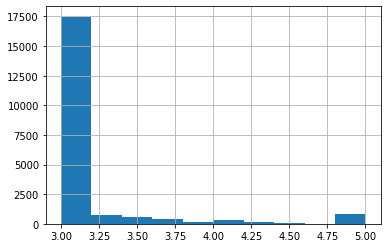

In [25]:
# test set
u_t_df['rating'].hist(bins=10)

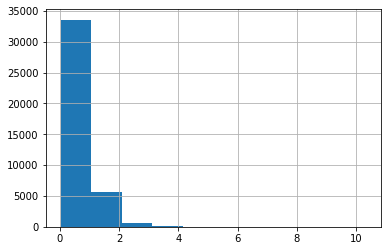

In [26]:
# nmf
nmf_at10_df['rating'].hist(bins=10)

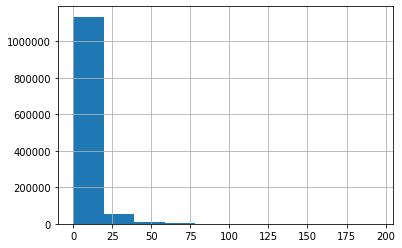

In [27]:
# knn - not normalized
u_rec_df_simp['rating'].hist(bins=10)

# <font color=orange> RE-RANKER </font>

In [28]:
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

## simplified reranker - similar to XQuAD

In [29]:
import warnings
warnings.filterwarnings("error")
import sklearn

# u is userid
# item_features is the list of all item-features
# res format: (user, array([itemid]), array([ratings]))
# fair_feat = the feature that is important to focus on like genres,...
def XQuAD_reranker(u, item_features, res, lam, top_k, fair_feat):
    
    new_rec_i = []
    new_rec_sc = []
    for i in range(len(res[u][1])):
        if res[u][1][i] in item_features.index:
            new_rec_i.append(res[u][1][i])
            new_rec_sc.append(res[u][2][i])

    new_rec_i = np.array(new_rec_i)
    new_rec_sc = np.array(new_rec_sc)
    
    # making sure that the scores are between zero and one across all users, similar to cosine score
    # otherwise how do we combine these two different scores
    scaler = MinMaxScaler()
    # scale the ratings for each user separately, does it matter at all? YES, it is needed when we combine two fairness and rating scores
    scaled_ratings = scaler.fit_transform(new_rec_sc.reshape(-1,1))[:,0]
    
    # find the ids of the items in the protected group
    fair_item_inlist_ids = np.where(item_features.loc[new_rec_i, pro_dict[fair_feat]].sum(axis=1).values > 0)[0]
    fair_items_ids = np.array(new_rec_i)[fair_item_inlist_ids]
    fair_scores = np.zeros(len(new_rec_i))
    fair_scores[fair_item_inlist_ids] = 1.0
    

    c = 0
    s = []
    for k in range(top_k): # top_k means choose top k items for the final re-ranking.
        all_sc = []
        # iterate through the items that are recommended to user.
        for rec_idx in range(len(new_rec_i)):

            r = scaled_ratings[rec_idx]            
            p = fair_scores[rec_idx]
            
            # boosting (+) the score of items that belong to the protected group by (1-lambda)
            sc = lam * r + (1-lam) * p
            
            # find the index of a user id and then go to that index to retrieve the score
            all_sc.append(sc) # 0.1 0.5 0.2   
            
    sc_asorted = np.argsort(all_sc)[::-1] # [1, 2, 0]
    top_ratings = np.sort(all_sc)[::-1][:top_k]
    top_items = new_rec_i[sc_asorted[:top_k]]
    
    return (u, top_items, top_ratings)

# OFAiR

In [30]:
import warnings
warnings.filterwarnings("error")
import sklearn

# u is userid, items of that user
# item_features is the list of all item-features
# res format: (user, array([itemid]), array([ratings]))
def mmr_opt(u, item_features, res, lam, top_k, w=None):
    
    new_rec_i = []
    new_rec_sc = []
    for i in range(len(res[u][1])):
        if res[u][1][i] in item_features.index:
            new_rec_i.append(res[u][1][i])
            new_rec_sc.append(res[u][2][i])
    new_rec_i = np.array(new_rec_i)
    new_rec_sc = np.array(new_rec_sc)
    
    # making sure that the scores are between zero and one across all users, similar to cosine score
    # otherwise how do we combine these two different scores
    scaler = MinMaxScaler()
    # scale the ratings for each user separately, does it matter at all?
    scaled_ratings = scaler.fit_transform(new_rec_sc.reshape(-1,1))[:,0]
    
    if w is not None:
        dists = sklearn.metrics.pairwise_distances(np.sqrt(w) * item_features.loc[new_rec_i], metric='cosine', n_jobs=1)
    else:
        dists = sklearn.metrics.pairwise_distances(item_features.loc[new_rec_i], metric='cosine', n_jobs=1)    

    c = 0
    s = []
    for k in range(top_k): # top_k means choose top k items for the final re-ranking.
        all_sc = []
        # iterate through the items that are recommended to user.
        # we choose the first 200 items.
        for rec_idx in range(len(new_rec_i)):
            p2 = 0
            for j in s:
                try:

                    # comparing item features
                    # the distances  of all items was calculated before for efficiancy
                    p = 1 - dists[rec_idx, new_rec_i.tolist().index(j)]
                    p2 += p
                except KeyError as e:
                    pass                         
            
            # mmr objective function
            # sc = lam * (1 - distance.cosine(u, items[i])) - (1-lam) * p2
            r = scaled_ratings[rec_idx]
            
            # get the index of an itemid and get the rating related to it
            sc = lam * r - (1-lam) * p2
            
            # find the index of a user id and then go to that index to retrieve the score
            all_sc.append(sc) # 0.1 0.5 0.2
               
                
        sc_asorted = np.argsort(all_sc)[::-1] # [1, 2, 0]
        sc_idx = 0
        top_item = new_rec_i[sc_asorted[0]]
        
        # if top item already exists in the list, pick the second best item or the third best item
        while top_item in s:
            top_item = new_rec_i[sc_asorted[sc_idx]]
            sc_idx += 1
        s.append(top_item)

    top_ratings = [new_rec_sc[list(new_rec_i).index(i)] for i in s]
    
    return (u, s, top_ratings)

# <font color=orange> user tolerance matrix</font>

In [31]:
userid_tolerance_dict = {} # key:userid, & value: a dictionary of genre : tolerance
# ACTIVITY_, COUNTRY_, GENDER_, loan_buck_, pfr_buck_ in their name

for userid in range(dataset.user_n):
    
    # creating an empty dictionary
    empty_dict = {}
    for k in ['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET']:
        empty_dict[k] = []

    # inner ids
    items_rated_before = np.nonzero(train_mat[userid, :])[1]
    i_f = item_features_df[item_features_df.index.isin(items_rated_before)].sum()
    
    for i in range(i_f.index.shape[0]):
        
        if 'ACTIVITY' in i_f.index[i]:
            empty_dict['ACTIVITY'].extend([i_f.index[i]] * int(i_f[i]))
        elif 'COUNTRY' in i_f.index[i]:
            empty_dict['COUNTRY'].extend([i_f.index[i]] * int(i_f[i]))
        elif 'GENDER' in i_f.index[i]:
            empty_dict['GENDER'].extend([i_f.index[i]] * int(i_f[i]))
        elif 'loan_buck' in i_f.index[i]:
            empty_dict['LOAN_BUCKET'].extend([i_f.index[i]] * int(i_f[i]))
        elif 'pfr_buck' in i_f.index[i]:
            empty_dict['PFR_BUCKET'].extend([i_f.index[i]] * int(i_f[i]))
            
        else:
            print('no feature found')
            
    # calculate entropy for each user over all the features
    # this is problematic for users who have a short profile.
    tolerance_dict = {} # feature: entropy
    for k, v in empty_dict.items():
        tolerance_dict[k] = entropy_(v)

    # {userid: {feature: entropy}}
    userid_tolerance_dict[userid] = tolerance_dict

print(len(userid_tolerance_dict))
print('example, userid 0:\n', userid_tolerance_dict[0])

# --------------------------------- Turning the userid_tolerance_dict into a matrix ------------------------------------
# Turning the userid_tolerance_dict into a matrix where each row is user id and columns are features and the values are entropies.
# Once we normalize the entropy based on users(rows) and once based on features(columns). 
# We normalize the values so it is between 0 and 2.
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


# userid_tolerance_dict
from sklearn.feature_extraction import DictVectorizer

# Create DictVectorizer object
dictvectorizer = DictVectorizer(sparse=False)

# Convert dictionary into feature matrix
features = dictvectorizer.fit_transform(userid_tolerance_dict.values())

# get column names
print (dictvectorizer.get_feature_names(),'\n')
print (features[:5], '\n')

# ----------------------------- normalizing the matrix --------------------------------------------------------------
# Transform the whole tolerance (feature) matrix between 0 and 1
# (X - MIN / MAX - MIN) * (NEW_MAX - NEW_MIN) + NEW_MIN
feature_max = np.max(features)
feature_min = np.min(features)
new_min = 0
new_max = 1

# print(feature_max, feature_min)
sc = (features - feature_min) / (feature_max - feature_min)
userid_tolerance_normed = sc * (new_max - new_min) + new_min

print(userid_tolerance_normed[:13], '\n')

# what are the feature names?
feature_names = dictvectorizer.get_feature_names()
print (feature_names)
print(feature_names.index('GENDER'))

# instead of zero we initialize the vector with epsilon, 
# why? to avoid division by zero and to allow a little bit of room for diversity in other categories
import sys
my_epsilon = sys.float_info.epsilon # 2.220446049250313e-16
userid_tolerance_normed += my_epsilon


userid_tolerance_normed_df = pd.DataFrame(userid_tolerance_normed, columns=dictvectorizer.get_feature_names())
print(userid_tolerance_normed_df.head(), '\n')

print ('how many features do we have', item_features_df.columns.values.shape[0], '\n')

# -------------------------------- turn it into a matrix ------------------------------------------
user_genre_matrix = []

for userid in range(dataset.user_n):
    
    user_tolerance_vector = []
    user_tolerance_vector.append(userid)
    
    for cat in item_features_df.columns.values.tolist():
    
        if 'ACTIVITY' in cat:
            c = 'ACTIVITY'
        elif 'COUNTRY' in cat:
            c = 'COUNTRY'
        elif 'GENDER' in cat:
            c = 'GENDER'
        elif 'loan_buck' in cat:
            c = 'LOAN_BUCKET'
        elif 'pfr_buck' in cat:
            c = 'PFR_BUCKET'

        u_cat_tol = userid_tolerance_normed_df.loc[userid, c]
        user_tolerance_vector.append(u_cat_tol)
    
    user_genre_matrix.append(user_tolerance_vector)


print (len(user_genre_matrix))
user_genre_matrix_df = pd.DataFrame(user_genre_matrix)
user_genre_matrix_df.columns = ['userid'] + item_features_df.columns.values.tolist()
user_genre_matrix_df.head()

# user_genre_matrix_df.to_csv('./RECSYS/kiva_results/Kiva_usr_cat_tol_mat_normalized.csv', index=None)

# ------------------------- creating the feat-dictionaary ----------------------------------

feat_dict = {}

for k in dictvectorizer.get_feature_names():
    feat_dict[k]=[]

for cat in item_features_df.columns.values.tolist():

    if 'ACTIVITY' in cat:
        c = 'ACTIVITY'
    elif 'COUNTRY' in cat:
        c = 'COUNTRY'
    elif 'GENDER' in cat:
        c = 'GENDER'
    elif 'loan_buck' in cat:
        c = 'LOAN_BUCKET'
    elif 'pfr_buck' in cat:
        c = 'PFR_BUCKET'
    
#     feat_dict[c] =[]
    feat_dict[c].append(cat)
    
print('example:', user_genre_matrix_df[feat_dict['GENDER']].head(), '\n')
print('example:', user_genre_matrix_df[feat_dict['COUNTRY']].head(), '\n')
print('feature names', dictvectorizer.get_feature_names())

# -------------------------------------- reading it ---------------------------------------------------
# user_genre_matrix_df = pd.read_csv('./RECSYS/kiva_results/Kiva_usr_cat_tol_mat_normalized.csv')
user_genre_matrix_df.set_index('userid', inplace=True)
user_genre_matrix_df.head()

4005
example, userid 0:
 {'ACTIVITY': 1.9722469794234416, 'COUNTRY': 1.2945451658448959, 'GENDER': 0.30463609734923813, 'LOAN_BUCKET': 1.4681399390162087, 'PFR_BUCKET': 1.2882523050229002}
['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET'] 

[[1.97224698 1.29454517 0.3046361  1.46813994 1.28825231]
 [2.96694349 2.65119298 0.51957984 1.96834871 1.36047951]
 [2.13338193 2.51265853 0.56233514 1.74796624 1.30509637]
 [2.78061913 2.93905277 0.57004717 2.09807921 1.30098996]
 [1.63263093 0.45056121 0.56233514 1.47350239 0.67919327]] 

[[0.48453255 0.31803789 0.07484159 0.36068585 0.31649189]
 [0.728905   0.65133287 0.12764798 0.48357484 0.33423633]
 [0.52411944 0.61729836 0.13815191 0.42943229 0.32063006]
 [0.68312969 0.72205294 0.14004656 0.51544643 0.31962122]
 [0.40109724 0.1106918  0.13815191 0.36200327 0.16686107]
 [0.46829531 0.51086761 0.13815191 0.36708206 0.22117076]
 [0.63014493 0.60394659 0.         0.4630665  0.28424339]
 [0.49621884 0.27538992 0.11648436 0.33576727 0

,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
userid,,,,,,,,,,,,,,,,,,,,,
0,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,...,0.360686,0.360686,0.360686,0.360686,0.360686,0.360686,0.316492,0.316492,0.316492,0.316492
1,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,...,0.483575,0.483575,0.483575,0.483575,0.483575,0.483575,0.334236,0.334236,0.334236,0.334236
2,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,...,0.429432,0.429432,0.429432,0.429432,0.429432,0.429432,0.320630,0.320630,0.320630,0.320630
3,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,...,0.515446,0.515446,0.515446,0.515446,0.515446,0.515446,0.319621,0.319621,0.319621,0.319621
4,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,...,0.362003,0.362003,0.362003,0.362003,0.362003,0.362003,0.166861,0.166861,0.166861,0.166861


In [32]:
print('tolerance for features:\n', userid_tolerance_normed_df.head(3), '\n')

tolerance for features:
    ACTIVITY   COUNTRY    GENDER  LOAN_BUCKET  PFR_BUCKET
0  0.484533  0.318038  0.074842     0.360686    0.316492
1  0.728905  0.651333  0.127648     0.483575    0.334236
2  0.524119  0.617298  0.138152     0.429432    0.320630 



In [33]:
user_genre_matrix_df.head()

,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
userid,,,,,,,,,,,,,,,,,,,,,
0,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,0.484533,...,0.360686,0.360686,0.360686,0.360686,0.360686,0.360686,0.316492,0.316492,0.316492,0.316492
1,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,0.728905,...,0.483575,0.483575,0.483575,0.483575,0.483575,0.483575,0.334236,0.334236,0.334236,0.334236
2,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,0.524119,...,0.429432,0.429432,0.429432,0.429432,0.429432,0.429432,0.320630,0.320630,0.320630,0.320630
3,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,0.683130,...,0.515446,0.515446,0.515446,0.515446,0.515446,0.515446,0.319621,0.319621,0.319621,0.319621
4,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,0.401097,...,0.362003,0.362003,0.362003,0.362003,0.362003,0.362003,0.166861,0.166861,0.166861,0.166861


In [34]:
print(feature_names)

['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET']


# <font color=orange>Fairness Definition</font>

### <font color='green'>IMP: we define the fairness dimensions and underrepresented groups based on the recommendation algorithms, not the training data.</font>

In [35]:
def get_item_freq_v(items):
    
    training_item_features_df_unique = item_features_df[item_features_df.index.isin(items)]
#     print(training_item_features_df_unique.head())
    
    all_item_feature_count = np.sum(training_item_features_df_unique.to_numpy(), axis=0)
    all_item_feature_count = pd.DataFrame([all_item_feature_count], columns=training_item_features_df_unique.columns)
    all_item_feature_count = pd.DataFrame(all_item_feature_count.T).rename(columns={0:'count'})
    all_item_feature_count.index.name = 'cat'
#     print(all_item_feature_count.T)
    
    # calculating the percentage
    freq_count = pd.DataFrame(columns=['cat', 'count'])

#     for key in feat_dict_filt.keys():
    for key in feat_dict.keys():
#         a_df = all_item_feature_count[all_item_feature_count.index.isin(feat_dict[key])]
        a_df = all_item_feature_count[all_item_feature_count.index.isin(feat_dict[key])]
        a_df_perc = a_df * 100.0 / a_df.sum() # divide by the total number of occurences in that catgory.
        a_df_perc = a_df_perc.reset_index(inplace=False)
        a_df_perc.columns = ['cat', 'count']
        freq_count = pd.concat([freq_count, a_df_perc], axis = 0)

    freq_count.sort_values(by='cat', inplace=True)
    freq_count.set_index('cat', inplace=True)
    genre_all_item_count = freq_count
    
    return genre_all_item_count
    

### calculate the frequency of features in recommendation and training set

In [36]:
items_tr = list(range(dataset.item_n))
print(dataset.item_n)

# items_rec_nmf = u_rec_df['itemid'].to_list()
items_rec_knnSimp = u_rec_df_simp['itemid'].tolist()

genre_all_item_count_tr = get_item_freq_v(items_tr)

# genre_all_item_count_rec = get_item_freq_v(items_rec_nmf)
genre_all_item_count_rec = get_item_freq_v(items_rec_knnSimp)

2673


In [37]:
genre_all_item_count_rec.T

cat,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
count,3.516648,0.0,1.459035,0.374111,0.374111,0.411523,0.935279,0.374111,1.571268,0.149645,...,10.213244,9.839132,9.913954,9.951366,9.988777,10.026188,25.028058,24.990647,24.990647,24.990647


In [38]:
genre_all_item_count_tr.T

cat,ACTIVITY_Agriculture,ACTIVITY_Air Conditioning,ACTIVITY_Animal Sales,ACTIVITY_Aquaculture,ACTIVITY_Arts,ACTIVITY_Auto Repair,ACTIVITY_Bakery,ACTIVITY_Barber Shop,ACTIVITY_Beauty Salon,ACTIVITY_Beekeeping,...,loan_buck_4,loan_buck_5,loan_buck_6,loan_buck_7,loan_buck_8,loan_buck_9,pfr_buck_0,pfr_buck_1,pfr_buck_2,pfr_buck_3
count,3.516648,0.0,1.459035,0.374111,0.374111,0.411523,0.935279,0.374111,1.571268,0.149645,...,10.213244,9.839132,9.913954,9.951366,9.988777,10.026188,25.028058,24.990647,24.990647,24.990647


In [39]:
pd.set_option('display.max_columns', None)

## calcualte the under-represented group

In [40]:
def get_under_rep_dims(thefeature, feat_dict, genre_all_item_count):
    
    # separate the dataframe for only the protected features
    thedimensions = genre_all_item_count[genre_all_item_count.index.isin(feat_dict[thefeature])]
    
    # if the frequency is less than the first quartile, it belongs to the under-represented group
    underrep_dims = thedimensions[(thedimensions['count'] <= float(thedimensions.quantile(0.25)))].index.tolist()

    return underrep_dims

In [41]:
pro = []
pro_dict = {}
unpro_dict = {}

for f in feat_dict:
    # changed genre_all_item_count_tr to genre_all_item_count_rec
    underrep_dims = get_under_rep_dims(f, feat_dict, genre_all_item_count_rec) 

    
    pro.extend(underrep_dims)
    pro_dict[f] = underrep_dims
    unpro_dict[f] = set(feat_dict[f]) - set(underrep_dims)
    
# print(pro)
# print()
# print(pro_dict)
# print()
# print(unpro_dict)

In [42]:
feat_dict.keys()

dict_keys(['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET'])

# <font color=orange>Fairness Metrics</font>

In [43]:
def isProtectedFeature(itemId, _theFeature):
    global notFoundItems
    try:
        if item_features_df.loc[item_features_df.index == itemId, pro_dict[_theFeature]].sum(axis=1).values[0] > 0:
            return True
    except IndexError:
#         print('item with ID %d NOT FOUND!' % itemId)
        notFoundItems.append(itemId)
    return False

def isUnprotectedFeature(itemId, _theFeature):
    global notFoundItems
    try:
        if item_features_df.loc[item_features_df.index == itemId, unpro_dict[_theFeature]].sum(axis=1).values[0] > 0:
            return True
    except IndexError:
#         print('item with ID %d NOT FOUND!' % itemId)
        notFoundItems.append(itemId)
    return False


In [44]:
theFeatureForExpo = 'None'
def featureExposure_par(itemid):
    try:
        if isProtectedFeature(itemid, theFeatureForExpo):
            return 1 # 1 for protected
        elif isUnprotectedFeature(itemid, theFeatureForExpo):
            return -1 # -1 for unprotected
    except IndexError:
        notFoundItems.append(itemid)
    return 0

'''for every feature what is the prepresentaion'''
def featureExposureFast(_recList, _theFeature):
    pro_c = 0.0
    unpro_c = 0.0
    notFoundItems = []
    
    global theFeatureForExpo
    theFeatureForExpo = _theFeature
    
    pool = Pool(processes=10)
    r = pool.map(featureExposure_par, _recList)
    pool.close()
    pool.join()
            
    for i in r:
        if i == 1:
            pro_c += 1
        elif i == -1:
            unpro_c += 1
    return (pro_c, unpro_c)


'''for every feature what is the prepresentaion'''
def featureExposure(_recList, _theFeature):
    pro_c = 0.0
    unpro_c = 0.0
    notFoundItems = []

    for itemid in _recList:
        try:
            if isProtectedFeature(itemid, _theFeature):
                pro_c += 1
            elif isUnprotectedFeature(itemid, _theFeature):
                unpro_c += 1
        except IndexError:
            notFoundItems.append(itemid)
    return (pro_c, unpro_c)

"""
min(a/b, b/a) * 100 >= p%
Instead of returning true or false, let's return the percentage, we deal with the rest later.
"""
def p_percent_rule(groupA, groupB, thePercentageRule=None):
    # the result should be greater or equal to percentage "p" to be acceptable. Conventionally we assume it is 80%.
    
    if (groupB == 0.0) & (groupA == 0.0):
#         print("both can't be zero")
        return 0
    
    # Define Positive infinity number
    ptive_inf = float('inf')
    
    ratio1 = ratio2 = 0.0
    try:
        ratio1 = groupA*1.0/groupB
        ratio2 = groupB*1.0/groupA
        
    except ZeroDivisionError:
        if (groupB == 0) & (groupA != 0) :
            ratio1 = ptive_inf
        elif (groupA == 0) & (groupB != 0):
            ratio2 = ptive_inf
        elif (groupB == 0) & (groupA == 0):
            ratio1 = ratio2 = 0
        return 0
#             print("both can't be zero")
    
    result = min([ratio1, ratio2])
    
#     print(result)
#     return  (result >= thePercentageRule)
    return (result)

In [45]:
# _recList: recommendation lists for users in the batch
# _base: base recommendation lists (of size 300 e.g.) for users in the batch
def featureRecall(_recList, _base, _theFeature):
    pro_c_rec = np.where(item_features_df.loc[_recList, pro_dict[_theFeature]].sum(axis=1).values > 0)[0].shape[0]
    recall = float(pro_c_rec) / len(_recList)#min(len(_recList), pro_c_base)
    return recall

# <font color='orange'>Dynamic Fairness Experiments</font>

In this experiment, users arrive one at a time, we leave the tolerance weights out and only rely on the fairness weights.

### choose the base recommender

In [69]:
# user-knn simple
# base_recs = u_rec_df_simp.copy()

# nmf 
base_recs = u_rec_df.copy()

### simulation parameters 

In [70]:
# simulation parameters:
batch_size = int(0.005 * dataset.user_n)
print('batch size = ', batch_size)

# time slots
max_time = 200

# so it 
window_size = 50

lam = 0.6 # maximum personalization

# threshold for running fair re-ranker
# if fairness is more than this, the reranker won't run.
theta_F = 0.6

# recommendation parameters
top_k = 10

batch size =  20


## <font color=orange> base recommendation - no reranking. </font>

In [48]:

feature_selected_attime = []

# recommendations of each user after re-ranking for fairness
all_base_recs = []

all_base_rec_items_batch_2 = []
all_rer_rec_items_batch = []
all_users_batch = []

# shuffle users
shuffled_users = base_recs.userid.unique().copy()
np.random.shuffle(shuffled_users)

notFoundItems = []

for time in range(max_time): 
    
    if time*batch_size >= len(shuffled_users):
        print('We have reached the end of adding all the users into the times (according to the batch_size=%d)!' % batch_size)
        print('So, this is the end. Exiting the time loop!')
        break
    
    batch_users = shuffled_users[time*batch_size: (time+1) * batch_size]
    all_users_batch.append(batch_users)

    base_rec_items = []
    pool_rs = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
        pool_rs.append((u, (u, items[:top_k], ratings[:top_k])))
        base_rec_items.extend(items)
        
    all_base_rec_items_batch_2.append(base_rec_items)
    
    ofair_recs = []
    for (user, (_, rer_items, rer_scores)) in pool_rs:
        for i in range(len(rer_items)):
            ofair_recs.append([user, rer_items[i], rer_scores[i]])
            all_base_recs.append([user, rer_items[i], rer_scores[i]])
    
    ofair_recs = pd.DataFrame(ofair_recs, columns=['userid', 'itemid', 'rating'])

    # ----------------------------------------------- fairness ---------------------------------------------------------------
    ofair_items = list(map(int, ofair_recs['itemid'].tolist()))
    all_rer_rec_items_batch.append(ofair_items)
    
    print('%d' % time, end=' ')
    
print('\nNumber of NotFound items in the time loop: %d' % len(notFoundItems))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
Number of NotFound items in the time loop: 0


In [49]:
expo_ratios_base = []
for t in range(1, len(all_rer_rec_items_batch)):
    selected_items = []
    base_items = []
    for tt in range(max(0, t-window_size), t, 1):
        selected_items.extend(all_rer_rec_items_batch[tt])
        base_items.extend(all_base_rec_items_batch_2[tt])
        
    expo_r = []
    for feat in feat_dict.keys(): #['genres', 'popularity', 'year']:
        # recall of protected items from the recommendations
        recall = featureRecall(selected_items, base_items, feat)
        print('%15s \t %.2f' % (feat, recall))
        expo_r.append(recall)
    expo_ratios_base.append(expo_r)
    
    print('@time: %d ' % t, end=' ')
    print('-'*100)

       ACTIVITY 	 0.01
        COUNTRY 	 0.07
         GENDER 	 0.35
    LOAN_BUCKET 	 0.30
     PFR_BUCKET 	 0.49
@time: 1  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.01
        COUNTRY 	 0.04
         GENDER 	 0.33
    LOAN_BUCKET 	 0.30
     PFR_BUCKET 	 0.52
@time: 2  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.01
        COUNTRY 	 0.04
         GENDER 	 0.28
    LOAN_BUCKET 	 0.27
     PFR_BUCKET 	 0.53
@time: 3  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.01
        COUNTRY 	 0.04
         GENDER 	 0.27
    LOAN_BUCKET 	 0.28
     PFR_BUCKET 	 0.54
@time: 4  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.01
        COUNTRY 	 0.05
         GENDER 	 0.27
    LOAN_BUCKET 	 0.29
    

In [50]:
pd.DataFrame(expo_ratios_base,
             columns=['ACTIVITY', 'COUNTRY', 'GENDER',
                      'LOAN_BUCKET', 'PFR_BUCKET']).to_csv('./RECSYS/SIGIR/base_ratios_kiva.csv', index=False)

In [51]:
def compute_evaluation(u):
    return (myEvaluations(u, u_t_df, ofair_recs))

# ======================================= Set the re-ranked fair recommendations in the input variable of DataFrame ======================================
ofair_recs = pd.DataFrame(all_base_recs, columns=['userid', 'itemid', 'rating'])
# ========================================================================================================================================================

evalList = []
pool = Pool(processes=10)
evalList = pool.map(compute_evaluation, ofair_recs.userid.unique())
pool.close()
pool.join()

pd.DataFrame([np.average(np.array(evalList), axis=0)], columns=['recall', 'precision', 'ndcg', 'ndcg_t', 'diversity_ild', 'diversity_entropy'])

,recall,precision,ndcg,ndcg_t,diversity_ild,diversity_entropy
0,0.07749,0.010075,0.050579,0.048786,0.423527,0.785073


## regret

In [52]:
regret = 0
for t in range(max_time-1):
    for d in range(len(feat_dict.keys())):
        regret += max(0, 1 - expo_ratios_base[t][d])
regret

780.0468822352165

## <font color=orange>Fixed lottery - Random dictator</font>

In [53]:

def random_choice(feat_dict):
    thefeature = random.choice(list(feat_dict.keys()))
    return thefeature


In [71]:
rr_count = []
rr_count_all =[]

# %%time
feature_selected_attime = []

# recommendations of each user after re-ranking for fairness
all_fair_recs__Rnd = []

all_expo_pprs = []
all_hit_pprs = []
evalList = []

all_base_rec_items_batch = []
all_rer_rec_items_batch = []
all_users_batch = []


# nmf recommendations
base_recs = u_rec_df.copy()

notFoundItems = []

for time in range(max_time): 
    
    if time*batch_size >= len(shuffled_users):
        print('We have reached the end of adding all the users into the times (according to the batch_size=%d)!' % batch_size)
        print('So, this is the end. Exiting the time loop!')
        break
    
    batch_users = shuffled_users[time*batch_size: (time+1) * batch_size]
    all_users_batch.append(batch_users)
    
    # Random Fairness Feature Selection
    selected_fair_feat = random_choice(feat_dict)
    
    feature_selected_attime.append(selected_fair_feat)

#     groupA, groupB = featureExposureFast(base_rec_items, selected_fair_feat)
#     ppr = p_percent_rule(groupA, groupB, 80)
    base_rec_items = []
    base_items = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
        base_rec_items.extend(items[:top_k])
        base_items.extend(items[:])
        
    all_base_rec_items_batch.append(base_rec_items)
    fairRecall =  featureRecall(base_rec_items, base_items, selected_fair_feat)
    ppr = fairRecall

    print('@time %d: Selected Feature for fairness: %15s  with recall= %.2f' % (time, selected_fair_feat, ppr))
    
    rr_count = []
    pool_rs = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
        if ppr < theta_F:
            #pool_rs.append(rerank_feature(u, np.array([(0, items, ratings)]), selected_fair_feat))
            pool_rs.append((u, XQuAD_reranker(0, item_features_df, np.array([(0, items, ratings)]), lam, top_k, selected_fair_feat)))
            rr_count.append(selected_fair_feat)
        else:
            print('skipping re-ranking for this time because of PPR!')
            pool_rs.append((u, (u, items[:top_k], ratings[:top_k])))
            
    rr_count_all.append(rr_count) # nasim
    
    ofair_recs = []
    for (user, (_, rer_items, rer_scores)) in pool_rs:
        for i in range(len(rer_items)):
            ofair_recs.append([user, rer_items[i], rer_scores[i]])
            all_fair_recs__Rnd.append([user, rer_items[i], rer_scores[i]])
    
    ofair_recs = pd.DataFrame(ofair_recs, columns=['userid', 'itemid', 'rating'])

    # ----------------------------------------------- fairness ---------------------------------------------------------------
    ofair_items = list(map(int, ofair_recs['itemid'].tolist()))
    all_rer_rec_items_batch.append(ofair_items)
    
    
print('\nNumber of NotFound items in the time loop: %d' % len(notFoundItems))

@time 0: Selected Feature for fairness:      PFR_BUCKET  with recall= 0.49
@time 1: Selected Feature for fairness:          GENDER  with recall= 0.30
@time 2: Selected Feature for fairness:         COUNTRY  with recall= 0.04
@time 3: Selected Feature for fairness:         COUNTRY  with recall= 0.03
@time 4: Selected Feature for fairness:        ACTIVITY  with recall= 0.00
@time 5: Selected Feature for fairness:     LOAN_BUCKET  with recall= 0.33
@time 6: Selected Feature for fairness:     LOAN_BUCKET  with recall= 0.21
@time 7: Selected Feature for fairness:          GENDER  with recall= 0.16
@time 8: Selected Feature for fairness:         COUNTRY  with recall= 0.09
@time 9: Selected Feature for fairness:      PFR_BUCKET  with recall= 0.48
@time 10: Selected Feature for fairness:        ACTIVITY  with recall= 0.00
@time 11: Selected Feature for fairness:          GENDER  with recall= 0.24
@time 12: Selected Feature for fairness:          GENDER  with recall= 0.14
@time 13: Selected Fea

In [72]:
# NEW 3
expo_ratios_rnd = [] # CHANGE THIS
for t in range(1, len(all_rer_rec_items_batch)):
    selected_items = []
    base_items = []
    for tt in range(max(0, t-window_size), t, 1):
        selected_items.extend(all_rer_rec_items_batch[tt])
        base_items.extend(all_base_rec_items_batch_2[tt])
        
    expo_r = []
    for feat in feat_dict.keys(): #['genres', 'popularity', 'year']:
        # recall of protected items from the recommendations
        recall = featureRecall(selected_items, base_items, feat)
        print('%15s \t %.2f' % (feat, recall))
        expo_r.append(recall)
        
    # CHANGE THIS
    expo_ratios_rnd.append(expo_r)
    
    print('@time: %d ' % t, end=' ')
    print('-'*100)

       ACTIVITY 	 0.00
        COUNTRY 	 0.05
         GENDER 	 0.23
    LOAN_BUCKET 	 0.27
     PFR_BUCKET 	 0.95
@time: 1  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.02
        COUNTRY 	 0.06
         GENDER 	 0.56
    LOAN_BUCKET 	 0.28
     PFR_BUCKET 	 0.71
@time: 2  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.01
        COUNTRY 	 0.28
         GENDER 	 0.47
    LOAN_BUCKET 	 0.27
     PFR_BUCKET 	 0.67
@time: 3  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.01
        COUNTRY 	 0.36
         GENDER 	 0.42
    LOAN_BUCKET 	 0.27
     PFR_BUCKET 	 0.65
@time: 4  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.07
        COUNTRY 	 0.30
         GENDER 	 0.41
    LOAN_BUCKET 	 0.28
    

## saving to file

In [56]:
pd.DataFrame(np.hstack((np.vstack(([0.0, 0.0, 0.0, 0.0, 0.0], expo_ratios_rnd)),
                        np.zeros((200, 5)) + 0.25,
                        np.array(feature_selected_attime).reshape(-1,1))),
             columns=['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET',
                      'p_act','p_cntry','p_gndr','p_loanbck', 'p_pfr',
                      'chosen_dim']).to_csv('./RECSYS/SIGIR/fixedlottery_ratios_kiva.csv', index=False)

In [73]:
def compute_evaluation(u):
    return (myEvaluations(u, u_t_df, ofair_recs))

# ======================================= Set the re-ranked fair recommendations in the input variable of DataFrame ======================================
ofair_recs = pd.DataFrame(all_fair_recs__Rnd, columns=['userid', 'itemid', 'rating'])
# ========================================================================================================================================================

evalList = []
pool = Pool(processes=10)
evalList = pool.map(compute_evaluation, ofair_recs.userid.unique())
pool.close()
pool.join()

pd.DataFrame([np.average(np.array(evalList), axis=0)], columns=['recall', 'precision', 'ndcg',
                                                                'ndcg_t', 'diversity_ild', 'diversity_entropy'])

,recall,precision,ndcg,ndcg_t,diversity_ild,diversity_entropy
0,0.059169,0.007725,0.039042,0.037269,0.422644,0.80473


In [74]:
regret = 0
for t in range(max_time-1):
    for d in range(len(feat_dict.keys())):
        regret += max(0, 1 - expo_ratios_rnd[t][d])
regret

673.7655548908499

#### the number of times a reranker is selected to run

In [75]:
from collections import Counter
for k, v in Counter(feature_selected_attime).items():
    print(k, v*20)

PFR_BUCKET 900
GENDER 680
COUNTRY 800
ACTIVITY 780
LOAN_BUCKET 840


#### the number of times a reranker is actually was run

# <font color=orange>Least Misery / Deterministic / Pick the worst </font>

In [60]:

def deterministic_choice(_window_recList, _window_baseRecs, _feature_names):
    '''choose the worst off feature.'''
    
    m = []
    for fee in _feature_names:
#         proG, unproG = eval(fair_metric)(_test_set, _recList, fee)
#         proG, unproG = featureExposureFast(_window_recList, fee)
#         m.append(p_percent_rule(proG, unproG))
        f_recall = featureRecall(_window_recList, _window_baseRecs, fee)
        m.append(f_recall)
    
    # it can have multiple worst values
    min_val_indxs = [i for i, e in enumerate(m) if e == min(m)]
    
    # randomly choose one of the indices of the min value
    theIndex = random.choice(min_val_indxs)
    
#     min_val = m[theIndex]
#     min_feat = list(feat_dict.keys())[theIndex]
    min_feat = list(_feature_names)[theIndex]
#     print(min_val, min_feat)

    return min_feat

### running it over multiple time slots

In [76]:
%%time
rr_count_all = []


all_fair_recs__Determine = []
feature_selected_attime = []

all_expo_pprs = []
all_hit_pprs = []
evalList = []

hist_reranked = []
hist_lens = [] # contains the length of re-ranked items in each time

hist_base_recs = []
hist_base_lens = []

all_base_rec_items_batch = []
all_rer_rec_items_batch = []
all_users_batch = []

notFoundItems = []
for time in range(max_time): 
    
    if time*batch_size >= len(shuffled_users):
        print('We have reached the end of adding all the users into the times (according to the batch_size=%d)!' % batch_size)
        print('So, this is the end. Exiting the time loop!')
        break
    
    batch_users = shuffled_users[time*batch_size: (time+1) * batch_size]
    all_users_batch.append(batch_users)
    
    # saving base recommendations to compare it with re-ranked results
    base_rec_items = []
    for u in batch_users:
        items = list(map(int, base_recs[base_recs['userid'] == u]['itemid'].tolist()))
        # only select top-k items
        base_rec_items.extend(items[:top_k])
    all_base_rec_items_batch.append(base_rec_items)
    
    
    if len(hist_reranked) == 0:
        # Random Fairness Feature Selection
        selected_fair_feat = random_choice(feat_dict)
    else:
        # Feature selection
        # the history is selected based on the re-ranked items in prevrious times (the last window_size number of re-ranked items)
        selected_fair_feat = deterministic_choice(hist_reranked[-1*np.sum(hist_lens[-1*window_size:]):], 
                                                  hist_base_recs[-1*np.sum(hist_base_lens[-1*window_size:]):], 
                                                  feat_dict.keys())
        
    feature_selected_attime.append(selected_fair_feat)
    

    base_rec_items = []
    base_items = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
        base_rec_items.extend(items[:top_k])
        base_items.extend(items[:])
        
    # history of long list of base recommendations. This will be used by featureRecall in deterministic choice function
    hist_base_lens.append(len(base_items))
    hist_base_recs.extend(base_items)
    
    all_base_rec_items_batch.append(base_rec_items)
    fairRecall =  featureRecall(base_rec_items, base_items, selected_fair_feat)
    ppr = fairRecall

    print('@time %d: Selected Feature for fairness: %15s  with recall= %.2f' % (time, selected_fair_feat, ppr))
    
    rr_count = []
#     base_rec_items = []
    pool_rs = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
#         base_rec_items.extend(items[:top_k])
        if ppr < theta_F:
#             pool_rs.append(rerank_feature(u, np.array([(0, items, ratings)]), selected_fair_feat))
            pool_rs.append((u, XQuAD_reranker(0, item_features_df, np.array([(0, items, ratings)]), lam, top_k, selected_fair_feat)))
            rr_count.append(selected_fair_feat)
        else:
            print('skipping re-ranking for this time because of PPR!')
            pool_rs.append((u, (u, items[:top_k], ratings[:top_k])))
#     all_base_rec_items_batch.append(base_rec_items)
    
    rr_count_all.append(rr_count)
    
    ofair_recs = []
    for (user, (_, rer_items, rer_scores)) in pool_rs:
        for i in range(len(rer_items)):
            ofair_recs.append([user, rer_items[i], rer_scores[i]])
            all_fair_recs__Determine.append([user, rer_items[i], rer_scores[i]])
            
    
    ofair_recs = pd.DataFrame(ofair_recs, columns=['userid', 'itemid', 'rating'])

    # ----------------------------------------------- fairness ---------------------------------------------------------------
    ofair_items = list(map(int, ofair_recs['itemid'].tolist()))
    all_rer_rec_items_batch.append(ofair_items)
    
    hist_reranked.extend(ofair_items)
    hist_lens.append(len(ofair_items))
    
    
print('\nNumber of NotFound items in the time loop: %d' % len(notFoundItems))

@time 0: Selected Feature for fairness:     LOAN_BUCKET  with recall= 0.30
@time 1: Selected Feature for fairness:        ACTIVITY  with recall= 0.01
@time 2: Selected Feature for fairness:         COUNTRY  with recall= 0.04
@time 3: Selected Feature for fairness:        ACTIVITY  with recall= 0.00
@time 4: Selected Feature for fairness:        ACTIVITY  with recall= 0.00
@time 5: Selected Feature for fairness:         COUNTRY  with recall= 0.06
@time 6: Selected Feature for fairness:        ACTIVITY  with recall= 0.01
@time 7: Selected Feature for fairness:        ACTIVITY  with recall= 0.01
@time 8: Selected Feature for fairness:         COUNTRY  with recall= 0.09
@time 9: Selected Feature for fairness:        ACTIVITY  with recall= 0.01
@time 10: Selected Feature for fairness:        ACTIVITY  with recall= 0.00
@time 11: Selected Feature for fairness:         COUNTRY  with recall= 0.07
@time 12: Selected Feature for fairness:        ACTIVITY  with recall= 0.00
@time 13: Selected Fea

In [77]:
# new random choice 3
expo_ratios_determine = []
for t in range(1, len(all_rer_rec_items_batch)):
    selected_items = []
    base_items = []
    for tt in range(max(0, t-window_size), t, 1):
        selected_items.extend(all_rer_rec_items_batch[tt])
        base_items.extend(all_base_rec_items_batch_2[tt])
        
    expo_r = []
    for feat in feat_dict.keys(): #['genres', 'popularity', 'year']:
        # recall of protected items from the recommendations
        recall = featureRecall(selected_items, base_items, feat)
        print('%15s \t %.2f' % (feat, recall))
        expo_r.append(recall)
        
    # CHANGE THIS
    expo_ratios_determine.append(expo_r)
    
    print('@time: %d ' % t, end=' ')
    print('-'*100)

       ACTIVITY 	 0.00
        COUNTRY 	 0.04
         GENDER 	 0.28
    LOAN_BUCKET 	 0.91
     PFR_BUCKET 	 0.41
@time: 1  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.19
        COUNTRY 	 0.02
         GENDER 	 0.31
    LOAN_BUCKET 	 0.60
     PFR_BUCKET 	 0.45
@time: 2  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.13
        COUNTRY 	 0.25
         GENDER 	 0.31
    LOAN_BUCKET 	 0.47
     PFR_BUCKET 	 0.50
@time: 3  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.17
        COUNTRY 	 0.19
         GENDER 	 0.29
    LOAN_BUCKET 	 0.43
     PFR_BUCKET 	 0.52
@time: 4  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.20
        COUNTRY 	 0.17
         GENDER 	 0.30
    LOAN_BUCKET 	 0.41
    

## save to file

In [63]:
pd.DataFrame(np.hstack((np.vstack(([0.0, 0.0, 0.0, 0.0, 0.0], expo_ratios_determine)),
                        np.array(feature_selected_attime).reshape(-1,1))),
             columns=['ACTIVITY', 'COUNTRY', 'GENDER',
                      'LOAN_BUCKET', 'PFR_BUCKET',
                      'chosen_dim']).to_csv('./RECSYS/SIGIR/leastmisery_ratios_kiva.csv', index=False)

In [78]:
def compute_evaluation(u):
    return (myEvaluations(u, u_t_df, ofair_recs))

# ======================================= Set the re-ranked fair recommendations in the input variable of DataFrame ======================================
ofair_recs = pd.DataFrame(all_fair_recs__Determine, columns=['userid', 'itemid', 'rating'])
# ========================================================================================================================================================

evalList = []
pool = Pool(processes=10)
evalList = pool.map(compute_evaluation, ofair_recs.userid.unique())
pool.close()
pool.join()

pd.DataFrame([np.average(np.array(evalList), axis=0)], columns=['recall', 'precision', 'ndcg',
                                                                'ndcg_t', 'diversity_ild', 'diversity_entropy'])

,recall,precision,ndcg,ndcg_t,diversity_ild,diversity_entropy
0,0.062157,0.0081,0.042383,0.040627,0.424029,0.816453


In [79]:
# regret
regret = 0
for t in range(max_time-1):
    for d in range(len(feat_dict.keys())):
        regret += max(0, 1 - expo_ratios_determine[t][d])
regret

677.8199645326791

In [80]:
# Counter(feature_selected_attime)
for k, v in Counter(feature_selected_attime).items():
    print(k, v*20)

LOAN_BUCKET 20
ACTIVITY 2720
COUNTRY 1260


In [81]:
f_lists = [] 
for item in rr_count_all:
    f_lists.extend(item)
    
Counter(f_lists)

Counter({'LOAN_BUCKET': 20, 'ACTIVITY': 2720, 'COUNTRY': 1260})

# <font color=orange>Dynamic lottery</font>

In [86]:
import random

def set_uf(aVector, _epsilon):
    '''calculating the reverse of a probability, since we should give higher probabilities to the worst off'''
    #why 1? because it's the maximum value that can be achieved.
    aVector = [1.0-item-_epsilon for item in aVector] # adding epsilon to avoid zero probability.
    aVector = np.abs(np.array(aVector)/np.sum(aVector))  # turn into probabilities
    return aVector


def dynamic_lottery(_window_recList, _window_baseRecs, _feature_names, tw, w):

    m = []
    for fee in _feature_names:
        f_recall = featureRecall(_window_recList, _window_baseRecs, fee)
        m.append(f_recall)

    # calcualting the probability distribution
    my_epsilon = 0.01 # setting this to avoid undefined values and as the fairness threshold.
    uf = set_uf(m, my_epsilon)
#     print(uf)

    '''sometimes the probability vector doesnt sum up to 1.'''
    # now choose - draw from the distribution
    final_choice = np.random.choice(list(_feature_names), size=1, replace=True, p = uf)[0]
    
    return(final_choice)

# needs debigging

In [87]:
rr_count_all = []
# %%time
all_fair_recs__Dynm = []
feature_selected_attime = []

all_expo_pprs = []
all_hit_pprs = []
evalList = []

hist_reranked = []
hist_lens = [] # contains the length of re-ranked items in each time

hist_base_recs = []
hist_base_lens = []

all_base_rec_items_batch = []
all_rer_rec_items_batch = []
all_users_batch = []


# first read the base recommendations
# user-knn
# base_recs = u_rec_df_simp.copy()

# nmf recommendations
base_recs = u_rec_df.copy()
notFoundItems = []

for time in range(max_time): 
    
    if time*batch_size >= len(shuffled_users):
        print('We have reached the end of adding all the users into the times (according to the batch_size=%d)!' % batch_size)
        print('So, this is the end. Exiting the time loop!')
        break
    
    batch_users = shuffled_users[time*batch_size: (time+1) * batch_size]
    all_users_batch.append(batch_users)
    
    # saving base recommendations to compare it with re-ranked results
    base_rec_items = []
    for u in batch_users:
        items = list(map(int, base_recs[base_recs['userid'] == u]['itemid'].tolist()))
        # only select top-k items
        base_rec_items.extend(items[:top_k])
    all_base_rec_items_batch.append(base_rec_items)
    
    
    if len(hist_reranked) == 0:
        # Random Fairness Feature Selection
        selected_fair_feat = random_choice(feat_dict)
    else:
        # Feature selection
        # the history is selected based on the re-ranked items in prevrious times (the last window_size number of re-ranked items)
        # selected_fair_feat = stochastic_choice([], hist_reranked[:np.sum(hist_lens[-1*window_size:])], 'featureExposure_2')
        selected_fair_feat = dynamic_lottery(hist_reranked[-1*np.sum(hist_lens[-1*window_size:]):], 
                                                hist_base_recs[-1*np.sum(hist_base_lens[-1*window_size:]):],
                                                feat_dict.keys(),
                                                tw=window_size+100, w=window_size)

    feature_selected_attime.append(selected_fair_feat)

    
    base_rec_items = []
    base_items = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
        base_rec_items.extend(items[:top_k])
        base_items.extend(items[:])
        
    # history of long list of base recommendations. This will be used by featureRecall in deterministic choice function
    hist_base_lens.append(len(base_items))
    hist_base_recs.extend(base_items)
    
    all_base_rec_items_batch.append(base_rec_items)
    fairRecall =  featureRecall(base_rec_items, base_items, selected_fair_feat)
    ppr = fairRecall

    print('@time %d: Selected Feature for fairness: %15s  with recall= %.2f' % (time, selected_fair_feat, ppr))
    
#     base_rec_items = []
    rr_count = []
    pool_rs = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
#         base_rec_items.extend(items[:top_k])
        if ppr < theta_F:
            #pool_rs.append(rerank_feature(u, np.array([(0, items, ratings)]), selected_fair_feat))
            pool_rs.append((u, XQuAD_reranker(0, item_features_df, np.array([(0, items, ratings)]), lam, top_k, selected_fair_feat)))
            rr_count.append(selected_fair_feat)
        else:
            print('skipping re-ranking for this time because of PPR!')
            pool_rs.append((u, (u, items[:top_k], ratings[:top_k])))
            
    rr_count_all.append(rr_count)
    
    ofair_recs = []
    for (user, (_, rer_items, rer_scores)) in pool_rs:
        for i in range(len(rer_items)):
            ofair_recs.append([user, rer_items[i], rer_scores[i]])
            all_fair_recs__Dynm.append([user, rer_items[i], rer_scores[i]])

    
    ofair_recs = pd.DataFrame(ofair_recs, columns=['userid', 'itemid', 'rating'])

    # ----------------------------------------------- fairness ---------------------------------------------------------------
    ofair_items = list(map(int, ofair_recs['itemid'].tolist()))
    all_rer_rec_items_batch.append(ofair_items)
    
    hist_reranked.extend(ofair_items)
    hist_lens.append(len(ofair_items))
    
    
print('\nNumber of NotFound items in the time loop: %d' % len(notFoundItems))

@time 0: Selected Feature for fairness:         COUNTRY  with recall= 0.07
@time 1: Selected Feature for fairness:        ACTIVITY  with recall= 0.01
@time 2: Selected Feature for fairness:          GENDER  with recall= 0.20
@time 3: Selected Feature for fairness:         COUNTRY  with recall= 0.03
@time 4: Selected Feature for fairness:      PFR_BUCKET  with recall= 0.57
@time 5: Selected Feature for fairness:     LOAN_BUCKET  with recall= 0.33
@time 6: Selected Feature for fairness:          GENDER  with recall= 0.24
@time 7: Selected Feature for fairness:     LOAN_BUCKET  with recall= 0.29
@time 8: Selected Feature for fairness:         COUNTRY  with recall= 0.09
@time 9: Selected Feature for fairness:         COUNTRY  with recall= 0.04
@time 10: Selected Feature for fairness:      PFR_BUCKET  with recall= 0.59
@time 11: Selected Feature for fairness:         COUNTRY  with recall= 0.07
@time 12: Selected Feature for fairness:        ACTIVITY  with recall= 0.00
@time 13: Selected Fea

In [117]:
# np.sum([0.28947368, 0.26461988 ,0.19298246, 0.00292398, 0.25584795])

In [88]:
# new random choice 3
expo_ratios_dynm = []
for t in range(1, len(all_rer_rec_items_batch)):
    selected_items = []
    base_items = []
    for tt in range(max(0, t-window_size), t, 1):
        selected_items.extend(all_rer_rec_items_batch[tt])
        base_items.extend(all_base_rec_items_batch_2[tt])
        
    expo_r = []
    for feat in feat_dict.keys(): #['genres', 'popularity', 'year']:
        # recall of protected items from the recommendations
        recall = featureRecall(selected_items, base_items, feat)
        print('%15s \t %.2f' % (feat, recall))
        expo_r.append(recall)
        
    # CHANGE THIS
    expo_ratios_dynm.append(expo_r)
    
    print('@time: %d ' % t, end=' ')
    print('-'*100)

       ACTIVITY 	 0.00
        COUNTRY 	 0.72
         GENDER 	 0.41
    LOAN_BUCKET 	 0.30
     PFR_BUCKET 	 0.62
@time: 1  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.19
        COUNTRY 	 0.36
         GENDER 	 0.38
    LOAN_BUCKET 	 0.29
     PFR_BUCKET 	 0.56
@time: 2  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.13
        COUNTRY 	 0.27
         GENDER 	 0.54
    LOAN_BUCKET 	 0.28
     PFR_BUCKET 	 0.53
@time: 3  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.10
        COUNTRY 	 0.35
         GENDER 	 0.47
    LOAN_BUCKET 	 0.28
     PFR_BUCKET 	 0.55
@time: 4  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.08
        COUNTRY 	 0.30
         GENDER 	 0.42
    LOAN_BUCKET 	 0.28
    

## save to file

In [89]:
pd.DataFrame(np.hstack((np.vstack(([0.0, 0.0, 0.0, 0.0, 0.0], expo_ratios_dynm)), np.array(feature_selected_attime).reshape(-1,1))),
             columns=['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET', 'chosen_dim']).to_csv('./result_faact/dynamiclotttery_ratios_kiva.csv', index=False)

In [90]:
def compute_evaluation(u):
    return (myEvaluations(u, u_t_df, ofair_recs))

# ======================================= Set the re-ranked fair recommendations in the input variable of DataFrame ======================================
ofair_recs = pd.DataFrame(all_fair_recs__Dynm, columns=['userid', 'itemid', 'rating'])
# ========================================================================================================================================================

evalList = []
pool = Pool(processes=10)
evalList = pool.map(compute_evaluation, ofair_recs.userid.unique())
pool.close()
pool.join()

pd.DataFrame([np.average(np.array(evalList), axis=0)], columns=['recall', 'precision', 'ndcg', 'ndcg_t', 'diversity_ild', 'diversity_entropy'])

,recall,precision,ndcg,ndcg_t,diversity_ild,diversity_entropy
0,0.058532,0.007775,0.03955,0.037957,0.422602,0.808035


In [91]:
# regret
regret = 0
for t in range(max_time-1):
    for d in range(len(feat_dict.keys())):
        regret += max(0, 1 - expo_ratios_dynm[t][d])
regret

667.4166288451443

In [92]:
Counter(feature_selected_attime)

Counter({'COUNTRY': 53,
         'ACTIVITY': 53,
         'GENDER': 33,
         'PFR_BUCKET': 24,
         'LOAN_BUCKET': 37})

In [93]:
for k, v in Counter(feature_selected_attime).items():
    print(k, v*20)

COUNTRY 1060
ACTIVITY 1060
GENDER 660
PFR_BUCKET 480
LOAN_BUCKET 740


In [94]:
f_lists = [] 
for item in rr_count_all:
    f_lists.extend(item)
    
Counter(f_lists)

Counter({'COUNTRY': 1060,
         'ACTIVITY': 1060,
         'GENDER': 660,
         'PFR_BUCKET': 440,
         'LOAN_BUCKET': 740})

# Sampling Lottery - Hysteresis Lottery - stochastic assignment

- TW (n): The number of forward samples. 
    - target window is the number of recommendations that provides a horizon for us based on which we want to correct the imbalance.
    - sample aggressiveness. set it 10% of the b*t.
- W (m): the number of samples we have observed.
    - w = t * b, where b is the batch size and t is the time interval (windows).
    - set w to 25% of the users.
- delta-F
    - if delta == 10%, stop reranking if we get close to 0.9.
- take lambda for the reranker = 0.6
- reranker i
- what we need to calculate => p_i is the probability that we run reranker i
- We have
    - uf = 1 - f - e
    - our target formally 1/n for each i, [1/n, 1/n, 1/n]
- We set up p_i = (tw * uf_i + w * uf_i - w * (1/n)) / tw
- This gives us p which is the discrete distribution we draw from (as above) and run the associated re-ranker.

In [95]:
import random


def check_lowerbound(uf, tw, w):
    '''Check if tw is an acceptable number.'''
    a = (w * uf[i] - w * (1.0/len(uf)))/(1 - uf[i])
    b = (w * (1.0/len(uf)) - w * uf[i])/(uf[i])
    lower_b = np.min([a, b])
    
    if tw < lower_b:
        return False
    return True

def set_uf(aVector, _epsilon):
    '''calculating the reverse of a probability, since we should give higher probabilities to the worst off'''
    #why 1? because it's the maximum value that can be achieved.
    aVector = [1.0-item-_epsilon for item in aVector] # adding epsilon to avoid zero probability.
    aVector = np.abs(np.array(aVector)/np.sum(aVector))  # turn into probabilities
    return aVector


def set_p(uf, tw, w):
    '''Tians' formula'''
    # p = [0.0]*len(uf)
    p = np.zeros(len(uf), dtype=np.float)
#     while True:
#         p = np.zeros(len(uf), dtype=np.float)
#         hasZeroProba = False
#         for i in range(len(p)):
#             p[i] += (tw * uf[i] + w * uf[i] - w * (1.0/len(uf))) / tw
            
#             if p[i] < 0:
#                 tw *= 2
#                 hasZeroProba = True
#         if hasZeroProba == False:
#             break
        
    for i in range(len(p)):
        p[i] += (tw * uf[i] + w * uf[i] - w * (1.0/len(uf))) / tw
        
        if p[i] < 0:
            p[i] = 0
    
    p /= np.sum(p)

    
    return list(p)


def sampling_lottery(_window_recList, _window_baseRecs, _feature_names, tw, w):
    # we have tw
    # we calcualte w = t * b which is basicually the # of users that we have had so far.
    m = []
    for fee in _feature_names:
#         proG, unproG = featureExposureFast(_window_recList, fee)
#         m.append(p_percent_rule(proG, unproG))
        f_recall = featureRecall(_window_recList, _window_baseRecs, fee)
        m.append(f_recall)

    # calcualting the probability distribution
    my_epsilon = 0.01 # setting this to avoid undefined values and as the fairness threshold.
    uf = set_uf(m, my_epsilon)
    
#     a = (w * uf[i] - w * (1.0/len(uf)))/(1 - uf[i])
#     b = (w * (1.0/len(uf)) - w * uf[i])/(uf[i])
#     lower_b = np.min([a, b])
#     print('lower_b', lower_b)
    
#     while tw < lower_b:
#         print('Increasing TW...')
#         tw += 1
    
    # based on Tian's formula
    p_uf = set_p(uf, tw, w)
    
    # now choose - draw from the distribution
    final_choice = np.random.choice(list(_feature_names), size=1, replace=True, p = p_uf)[0]
    
    return(p_uf, final_choice)

In [96]:
%%time
rr_count_all = []
all_fair_recs__Hyst = []
feature_selected_attime = []
recall_list_attime = []

all_expo_pprs = []
all_hit_pprs = []
evalList = []

hist_reranked = []
hist_lens = [] # contains the length of re-ranked items in each time

hist_base_recs = []
hist_base_lens = []

all_base_rec_items_batch = []
all_rer_rec_items_batch = []
all_users_batch = []


# first read the base recommendations
# user-knn
# base_recs = u_rec_df_simp.copy()

# nmf recommendations
base_recs = u_rec_df.copy()
notFoundItems = []

for time in range(max_time): 
    
    if time*batch_size >= len(shuffled_users):
        print('We have reached the end of adding all the users into the times (according to the batch_size=%d)!' % batch_size)
        print('So, this is the end. Exiting the time loop!')
        break
    
    batch_users = shuffled_users[time*batch_size: (time+1) * batch_size]
    all_users_batch.append(batch_users)
    
    # saving base recommendations to compare it with re-ranked results
    base_rec_items = []
    for u in batch_users:
        items = list(map(int, base_recs[base_recs['userid'] == u]['itemid'].tolist()))
        # only select top-k items
        base_rec_items.extend(items[:top_k])
    all_base_rec_items_batch.append(base_rec_items)
    
    
    if len(hist_reranked) == 0:
        # Random Fairness Feature Selection
        selected_fair_feat = random_choice(feat_dict)
        pufl = [0.25]*len(feat_dict.keys())
    else:
        # Feature selection
        # the history is selected based on the re-ranked items in prevrious times (the last window_size number of re-ranked items)
        # selected_fair_feat = stochastic_choice([], hist_reranked[:np.sum(hist_lens[-1*window_size:])], 'featureExposure_2')
        pufl, selected_fair_feat = sampling_lottery(hist_reranked[-1*np.sum(hist_lens[-1*window_size:]):], 
                                                hist_base_recs[-1*np.sum(hist_base_lens[-1*window_size:]):],
                                                feat_dict.keys(),
                                                tw=window_size+100, w=window_size)

    feature_selected_attime.append(selected_fair_feat)
    recall_list_attime.append(pufl)

    
    base_rec_items = []
    base_items = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
        base_rec_items.extend(items[:top_k])
        base_items.extend(items[:])
        
    # history of long list of base recommendations. This will be used by featureRecall in deterministic choice function
    hist_base_lens.append(len(base_items))
    hist_base_recs.extend(base_items)
    
    all_base_rec_items_batch.append(base_rec_items)
    fairRecall =  featureRecall(base_rec_items, base_items, selected_fair_feat)
    ppr = fairRecall

    print('@time %d: Selected Feature for fairness: %15s  with recall= %.2f' % (time, selected_fair_feat, ppr))
    
    rr_count = []
#     base_rec_items = []
    pool_rs = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
#         base_rec_items.extend(items[:top_k])
        if ppr < theta_F:
            #pool_rs.append(rerank_feature(u, np.array([(0, items, ratings)]), selected_fair_feat))
            pool_rs.append((u, XQuAD_reranker(0, item_features_df, np.array([(0, items, ratings)]), lam, top_k, selected_fair_feat)))
            rr_count.append(selected_fair_feat)
        else:
            print('skipping re-ranking for this time because of PPR!')
            pool_rs.append((u, (u, items[:top_k], ratings[:top_k])))
            
    rr_count_all.append(rr_count)       
    
    
    ofair_recs = []
    for (user, (_, rer_items, rer_scores)) in pool_rs:
        for i in range(len(rer_items)):
            ofair_recs.append([user, rer_items[i], rer_scores[i]])
            all_fair_recs__Hyst.append([user, rer_items[i], rer_scores[i]])
    
    
    ofair_recs = pd.DataFrame(ofair_recs, columns=['userid', 'itemid', 'rating'])

    # ----------------------------------------------- fairness ---------------------------------------------------------------
    ofair_items = list(map(int, ofair_recs['itemid'].tolist()))
    all_rer_rec_items_batch.append(ofair_items)
    
    hist_reranked.extend(ofair_items)
    hist_lens.append(len(ofair_items))
    
    
print('\nNumber of NotFound items in the time loop: %d' % len(notFoundItems))

@time 0: Selected Feature for fairness:      PFR_BUCKET  with recall= 0.49
@time 1: Selected Feature for fairness:     LOAN_BUCKET  with recall= 0.30
@time 2: Selected Feature for fairness:         COUNTRY  with recall= 0.04
@time 3: Selected Feature for fairness:     LOAN_BUCKET  with recall= 0.32
@time 4: Selected Feature for fairness:          GENDER  with recall= 0.30
@time 5: Selected Feature for fairness:          GENDER  with recall= 0.21
@time 6: Selected Feature for fairness:      PFR_BUCKET  with recall= 0.58
@time 7: Selected Feature for fairness:     LOAN_BUCKET  with recall= 0.29
@time 8: Selected Feature for fairness:        ACTIVITY  with recall= 0.00
@time 9: Selected Feature for fairness:     LOAN_BUCKET  with recall= 0.30
@time 10: Selected Feature for fairness:          GENDER  with recall= 0.23
@time 11: Selected Feature for fairness:         COUNTRY  with recall= 0.07
@time 12: Selected Feature for fairness:        ACTIVITY  with recall= 0.00
@time 13: Selected Fea

In [97]:
# new random choice 3
expo_ratios_hyst = []
for t in range(1, len(all_rer_rec_items_batch)):
    selected_items = []
    base_items = []
    for tt in range(max(0, t-window_size), t, 1):
        selected_items.extend(all_rer_rec_items_batch[tt])
        base_items.extend(all_base_rec_items_batch_2[tt])
        
    expo_r = []
    for feat in feat_dict.keys(): #['genres', 'popularity', 'year']:
        # recall of protected items from the recommendations
        recall = featureRecall(selected_items, base_items, feat)
        print('%15s \t %.2f' % (feat, recall))
        expo_r.append(recall)
        
    # CHANGE THIS
    expo_ratios_hyst.append(expo_r)
    
    print('@time: %d ' % t, end=' ')
    print('-'*100)

       ACTIVITY 	 0.00
        COUNTRY 	 0.05
         GENDER 	 0.23
    LOAN_BUCKET 	 0.27
     PFR_BUCKET 	 0.95
@time: 1  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.00
        COUNTRY 	 0.04
         GENDER 	 0.23
    LOAN_BUCKET 	 0.59
     PFR_BUCKET 	 0.71
@time: 2  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.00
        COUNTRY 	 0.27
         GENDER 	 0.26
    LOAN_BUCKET 	 0.47
     PFR_BUCKET 	 0.67
@time: 3  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.00
        COUNTRY 	 0.20
         GENDER 	 0.24
    LOAN_BUCKET 	 0.57
     PFR_BUCKET 	 0.61
@time: 4  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.00
        COUNTRY 	 0.20
         GENDER 	 0.37
    LOAN_BUCKET 	 0.51
    

## save to file

In [98]:
pd.DataFrame(np.hstack((np.vstack(([0.0, 0.0, 0.0, 0.0, 0.0], expo_ratios_hyst)), recall_list_attime, np.array(feature_selected_attime).reshape(-1,1))),
             columns=['ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET',
                      'p_act','p_cntry','p_gndr','p_loanbck', 'p_pfr',
                      'chosen_dim']).to_csv('./result_faact/samplelottery_ratios_kiva.csv', index=False)

In [99]:
def compute_evaluation(u):
    return (myEvaluations(u, u_t_df, ofair_recs))

# ======================================= Set the re-ranked fair recommendations in the input variable of DataFrame ======================================
ofair_recs = pd.DataFrame(all_fair_recs__Hyst, columns=['userid', 'itemid', 'rating'])
# ========================================================================================================================================================

evalList = []
pool = Pool(processes=10)
evalList = pool.map(compute_evaluation, ofair_recs.userid.unique())
pool.close()
pool.join()

pd.DataFrame([np.average(np.array(evalList), axis=0)], columns=['recall', 'precision', 'ndcg',
                                                                'ndcg_t', 'diversity_ild', 'diversity_entropy'])

,recall,precision,ndcg,ndcg_t,diversity_ild,diversity_entropy
0,0.057752,0.007375,0.039072,0.038058,0.422142,0.807321


In [100]:
# regret
regret = 0
for t in range(max_time-1):
    for d in range(len(feat_dict.keys())):
        regret += max(0, 1 - expo_ratios_hyst[t][d])
regret

673.5495612187777

In [101]:
# Counter(feature_selected_attime)

In [102]:
for k, v in Counter(feature_selected_attime).items():
    print(k, v*20)

PFR_BUCKET 540
LOAN_BUCKET 680
COUNTRY 760
GENDER 780
ACTIVITY 1240


In [104]:
f_lists = [] 
for item in rr_count_all:
    f_lists.extend(item)
    
Counter(f_lists)

Counter({'PFR_BUCKET': 520,
         'LOAN_BUCKET': 680,
         'COUNTRY': 760,
         'GENDER': 780,
         'ACTIVITY': 1240})

# Probabilistic Serial Allocation

In [105]:
# Nick's code
import itertools
import copy
import random
import math
from fractions import Fraction as fraction

def eatingAssignment(prefs, agents, _items, capacities={}):
    #initialize an empty assignment for each agent...
    alloc = {cagent:{citem:fraction(0,1) for citem in _items} for cagent in agents}
    
#     print(_items)
    # If we get an empty dict,
    #intialize all items to be completely present ITEM ---> fraction remaining
    if capacities == {}:
        itemsremaining = {citem:fraction(1,1) for citem in _items}
    else:
        itemsremaining = capacities
#     print(itemsremaining)
#     print(capacities)
    
    #make a local copy of the preferences... we're going to destroy it...
    lps = copy.copy(prefs)
    
    #Keep going until all items are assigned...
    AllAllocated = False
    while not AllAllocated:
        #update demand list for each agent
        demand = {}
        for cagent in agents:
            #update the available items for cagent
#             print(cagent, itemsremaining)
            lps[cagent] = deleteAllocated(lps[cagent], itemsremaining)
            #demand is the minimal element
            demand[cagent] = lps[cagent][min(lps[cagent].keys())]
            #demand AGENT ---> HOUSE

        
        #find the eaters for every item.
        eating = {}   # HOUSE ----> NUM EATERS!
        for item in demand.values():
            eating[item] = (eating.get(item, 0) + 1)
        
        #find the minimum amount of house allocated this round
        minimalfraction = min([itemsremaining[item]/eating[item] for item in eating.keys()])
        
        #For every agent, assign the minimal fraction to each eater...
        for agent in demand.keys():
            alloc[agent][demand[agent]] += minimalfraction
            itemsremaining[demand[agent]] -= minimalfraction
        
        #Update allocations.
        #check to see if all items are 0:
        for ci in itemsremaining.values():
            if ci > 0:
                break
        else:
            AllAllocated = True

    return alloc

'''
Helper function to delete allocated items; only called from eatingAssignment.
'''
def deleteAllocated(apref, left):
    #manually copy this, if it's still there, okay.
    upref = {}
    for key in apref.keys():
        if left[apref[key]] > 0:
            upref[key] = apref[key]
    return upref

In [106]:
# Nasim's code:
def get_agent_ranks(feature_names, usr_tol_mat):
    
    objects = feature_names
    agent_ranks = {}

    for userid, row in enumerate(usr_tol_mat):
        user_pref = {}
        for indx, obj_inx in enumerate(np.argsort(row)[::-1]):
            user_pref[indx] = objects[obj_inx]
        agent_ranks[userid] = user_pref

    return(agent_ranks)


def get_capacities(uf, tw, _feature_names):
    from fractions import Fraction
    # let's say tw = 100, so we want to calucalte it for the next 100 users.
    capacities = {}
    uf_tw = np.array(uf) * tw
    
    for fee, fair_value in zip(_feature_names, uf_tw):
#         print(fee, fair_value)
        capacities[fee] =  Fraction(round(fair_value))

    return capacities


def inner_probabilistic_serial_allocation(batchUserList, uf, tw, userid_tolerance_normed_df, _feature_names):
    '''This should be run every TW since we are taking the view that we are allocating Re-rankers to users.'''
    # Build up the profile...
#     agents = list(range(dataset.user_n))
    agents = batchUserList
    objects = list(_feature_names) # whether we use featurenames of feat_dict matters. the ordering will change. be careful. 
    # this is coherent with the way userid_tolerance_normed 2d numpy array is.

    # Pass in a Preference Profile of just rankings
    # So each agent passes the rank of the object (this is different than the other one).
    # nasim: we can calulate the above based on the tolerance distributions and order the features for each user.
    
    # filtering out the features that we want & turning it into 2d numpy array
    usr_tol_filt = userid_tolerance_normed_df[objects].values

    agent_ranks = get_agent_ranks(objects, usr_tol_filt)
#     print(agent_ranks)
    '''Question: are all the users in the user tolerance matrix? should we check that?'''

    # You need to pass in the capacity of each object as a FRACTION!
    # You can pass empty capactites for all uniform
#     capacities = {"o1":fraction(1,2), "o2":fraction(1,1), "o3":fraction(1,1)}
    capacities = get_capacities(uf, tw, _feature_names)
    allocation = eatingAssignment(agent_ranks, agents, objects, capacities)

    batch_user_selected = []
    for a in agents:
        d = [float(allocation[a][o]) for o in objects]
#         print("Lottery for Agent {}: {}".format(a, d))
        
        p_d = np.abs(np.array(d)/np.sum(d))  # turn into probabilities
#         print(p_d)
        
        final_choice = np.random.choice(list(_feature_names), size=1, replace=True, p = p_d)[0]
        #print(final_choice)
        batch_user_selected.append((a, final_choice))
    
    return batch_user_selected


def probabilistic_serial_allocation(_window_recList, _window_baseRecs, batch_users, _feature_names, tw):
    m = []
    for fee in _feature_names:
#         proG, unproG = featureExposureFast(_window_recList, fee)
#         m.append(p_percent_rule(proG, unproG))
        f_recall = featureRecall(_window_recList, _window_baseRecs, fee)
        m.append(f_recall)

    # calcualting the probability distribution
    my_epsilon = 0.01 # setting this to avoid undefined values and as the fairness threshold.
    uf = set_uf(m, my_epsilon)

    #userList = _window_recList['userid'].tolist()

    final_choice = inner_probabilistic_serial_allocation(batch_users, uf, tw, userid_tolerance_normed_df, _feature_names)
    return final_choice

In [107]:
%%time
rr_count_all = []
# re-ranked recommendations for users in batches of this simulation
all_fair_recs__PSerialAloc = []

feature_selected_attime = []
feature_selected_attime2 = []

all_expo_pprs = []
all_hit_pprs = []
evalList = []

hist_reranked = []
hist_lens = [] # contains the length of re-ranked items in each time

all_base_rec_items_batch = []
all_rer_rec_items_batch = []
all_users_batch = []


# nmf recommendations
base_recs = u_rec_df.copy()

notFoundItems = []

for time in range(max_time): 
    
    if time*batch_size >= len(shuffled_users):
        print('We have reached the end of adding all the users into the times (according to the batch_size=%d)!' % batch_size)
        print('So, this is the end. Exiting the time loop!')
        break
    
    batch_users = shuffled_users[time*batch_size: (time+1) * batch_size]
    all_users_batch.append(batch_users)
    
    # saving base recommendations to compare it with re-ranked results
    base_rec_items = []
    for u in batch_users:
        items = list(map(int, base_recs[base_recs['userid'] == u]['itemid'].tolist()))
        # only select top-k items
        base_rec_items.extend(items[:top_k])
    all_base_rec_items_batch.append(base_rec_items)
    
    
    if len(hist_reranked) == 0:
        # Random Fairness Feature Selection
        selected_fair_feat = random_choice(feat_dict)
    else:
        # Feature selection
        # the history is selected based on the re-ranked items in prevrious times (the last window_size number of re-ranked items)
        # parameters: (_window_recList, batch_users, feature_names, tw)
        selected_fair_feat = probabilistic_serial_allocation(hist_reranked[-1*np.sum(hist_lens[-1*window_size:]):],
                                                             hist_base_recs[-1*np.sum(hist_base_lens[-1*window_size:]):],
                                                             shuffled_users,
                                                             feat_dict.keys(),
                                                             tw=window_size+50)

#     print('Selected Feature for fairness: %s' % selected_fair_feat)
    feature_selected_attime.append(selected_fair_feat)
    
    
    if len(hist_reranked) > 0:
        user_select_feat = {}
        for f in selected_fair_feat:
            if f[0] in batch_users:
                user_select_feat[f[0]] = f[1]
    
    
#     groupA, groupB = featureExposureFast(base_rec_items, selected_fair_feat)
#     ppr = p_percent_rule(groupA, groupB, 80)

#     print('@time %d: Selected Feature for fairness: %15s  with ppr= %.2f' % (time, selected_fair_feat, ppr))
    
    rr_count = []
    base_rec_items = []
    base_items = []
    pool_rs = []
    for u in batch_users:
        u_item_ratings = base_recs[base_recs['userid'] == u][['itemid', 'rating']]
        items = list(map(int, u_item_ratings['itemid'].tolist()))
        ratings = list(u_item_ratings['rating'].tolist())
        base_rec_items.extend(items[:top_k])
        base_items.extend(items[:])
        if len(hist_reranked) == 0:
            #pool_rs.append(rerank_feature(u, np.array([(0, items, ratings)]), selected_fair_feat))
            pool_rs.append((u, XQuAD_reranker(0, item_features_df, np.array([(0, items, ratings)]), lam, top_k, selected_fair_feat)))
            rr_count.append(selected_fair_feat)
        else:
            #pool_rs.append(rerank_feature(u, np.array([(0, items, ratings)]), user_select_feat[u]))
            pool_rs.append((u, XQuAD_reranker(0, item_features_df, np.array([(0, items, ratings)]), lam, top_k, user_select_feat[u])))
            rr_count.append(user_select_feat[u])
    
    rr_count_all.append(rr_count)
    
    all_base_rec_items_batch.append(base_rec_items)
    # history of long list of base recommendations. This will be used by featureRecall in deterministic choice function
    hist_base_lens.append(len(base_items))
    hist_base_recs.extend(base_items)
    
    feature_selected_attime2.append(rr_count)
    
    ofair_recs = []
    for (user, (_, rer_items, rer_scores)) in pool_rs:
        for i in range(len(rer_items)):
            ofair_recs.append([user, rer_items[i], rer_scores[i]])
            all_fair_recs__PSerialAloc.append([user, rer_items[i], rer_scores[i]])
            
    
    ofair_recs = pd.DataFrame(ofair_recs, columns=['userid', 'itemid', 'rating'])

    # ----------------------------------------------- fairness ---------------------------------------------------------------
    ofair_items = list(map(int, ofair_recs['itemid'].tolist()))
    all_rer_rec_items_batch.append(ofair_items)
    
    hist_reranked.extend(ofair_items)
    hist_lens.append(len(ofair_items))
    
    print('%d' % time, end=' ')
    
print('\nNumber of NotFound items in the time loop: %d' % len(notFoundItems))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
Number of NotFound items in the time loop: 0
CPU times: user 2min 4s, sys: 1.14 s, total: 2min 5s
Wall time: 2min 4s


In [108]:
# new random choice 3
expo_ratios_PSerialAloc = []
for t in range(1, len(all_rer_rec_items_batch)):
    selected_items = []
    base_items = []
    for tt in range(max(0, t-window_size), t, 1):
        selected_items.extend(all_rer_rec_items_batch[tt])
        base_items.extend(all_base_rec_items_batch_2[tt])
        
    expo_r = []
    for feat in feat_dict.keys(): #['genres', 'popularity', 'year']:
        # recall of protected items from the recommendations
        recall = featureRecall(selected_items, base_items, feat)
        print('%15s \t %.2f' % (feat, recall))
        expo_r.append(recall)
        
    # CHANGE THIS
    expo_ratios_PSerialAloc.append(expo_r)
    
    print('@time: %d ' % t, end=' ')
    print('-'*100)

       ACTIVITY 	 0.02
        COUNTRY 	 0.10
         GENDER 	 0.88
    LOAN_BUCKET 	 0.28
     PFR_BUCKET 	 0.47
@time: 1  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.06
        COUNTRY 	 0.22
         GENDER 	 0.63
    LOAN_BUCKET 	 0.32
     PFR_BUCKET 	 0.55
@time: 2  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.05
        COUNTRY 	 0.20
         GENDER 	 0.54
    LOAN_BUCKET 	 0.34
     PFR_BUCKET 	 0.56
@time: 3  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.06
        COUNTRY 	 0.18
         GENDER 	 0.48
    LOAN_BUCKET 	 0.36
     PFR_BUCKET 	 0.57
@time: 4  ----------------------------------------------------------------------------------------------------
       ACTIVITY 	 0.08
        COUNTRY 	 0.19
         GENDER 	 0.49
    LOAN_BUCKET 	 0.36
    

## save to file

In [109]:
u_t_p_tol = []
for t in range(0, max_time):   
    
    # take the users in each time step
    u_batch = all_users_batch[t]
    u_batch_prob = ([[0.25, 0.25, 0.25, 0.25, 0.25]] + expo_ratios_PSerialAloc)[t]
    
    if t != 0:
        df_at_t = pd.DataFrame(feature_selected_attime[t]) # userid, final choice for that user at time t
    
    u_b = []
    for u in u_batch:
        alist = []
        alist.append(u) #userid
        alist.append(t) #timestep
        alist.extend(u_batch_prob) #probabilities
        alist.extend(userid_tolerance_normed[u].tolist()) #tolerance weights
        
        #final choice for user u at time t
        if t!=0:
            alist.append(df_at_t[df_at_t[0] == u][1].values[0])
        else:
            alist.append(feature_selected_attime[t])
        
        u_b.append(alist)
    
    u_t_p_tol.extend(u_b)

    
# saving to file
pd.DataFrame(u_t_p_tol, columns=['userid','time_step',
                                 'ACTIVITY', 'COUNTRY', 'GENDER', 'LOAN_BUCKET', 'PFR_BUCKET',
                                 'p_act','p_cntry','p_gndr','p_loanbck', 'p_pfr',
                                 'chosen_dim']).to_csv('./result_faact/pslottery_ratios_kiva.csv', index=False)


In [110]:
def compute_evaluation(u):
    return (myEvaluations(u, u_t_df, ofair_recs))

# ======================================= Set the re-ranked fair recommendations in the input variable of DataFrame ======================================
ofair_recs = pd.DataFrame(all_fair_recs__PSerialAloc, columns=['userid', 'itemid', 'rating'])
# ========================================================================================================================================================

evalList = []
pool = Pool(processes=10)
evalList = pool.map(compute_evaluation, ofair_recs.userid.unique())
pool.close()
pool.join()

pd.DataFrame([np.average(np.array(evalList), axis=0)], columns=['recall', 'precision', 'ndcg', 'ndcg_t', 'diversity_ild', 'diversity_entropy'])

,recall,precision,ndcg,ndcg_t,diversity_ild,diversity_entropy
0,0.059095,0.00765,0.038143,0.036559,0.422838,0.805169


In [111]:
regret = 0
for t in range(max_time-1):
    for d in range(len(feat_dict.keys())):
        regret += max(0, 1 - expo_ratios_PSerialAloc[t][d])
regret

667.3407945216139

In [112]:
f_lists = [] 
for item in feature_selected_attime2:
    f_lists.extend(item)
    
Counter(f_lists)

Counter({'GENDER': 770,
         'LOAN_BUCKET': 706,
         'COUNTRY': 942,
         'ACTIVITY': 1082,
         'PFR_BUCKET': 500})

# Cumulative Regret

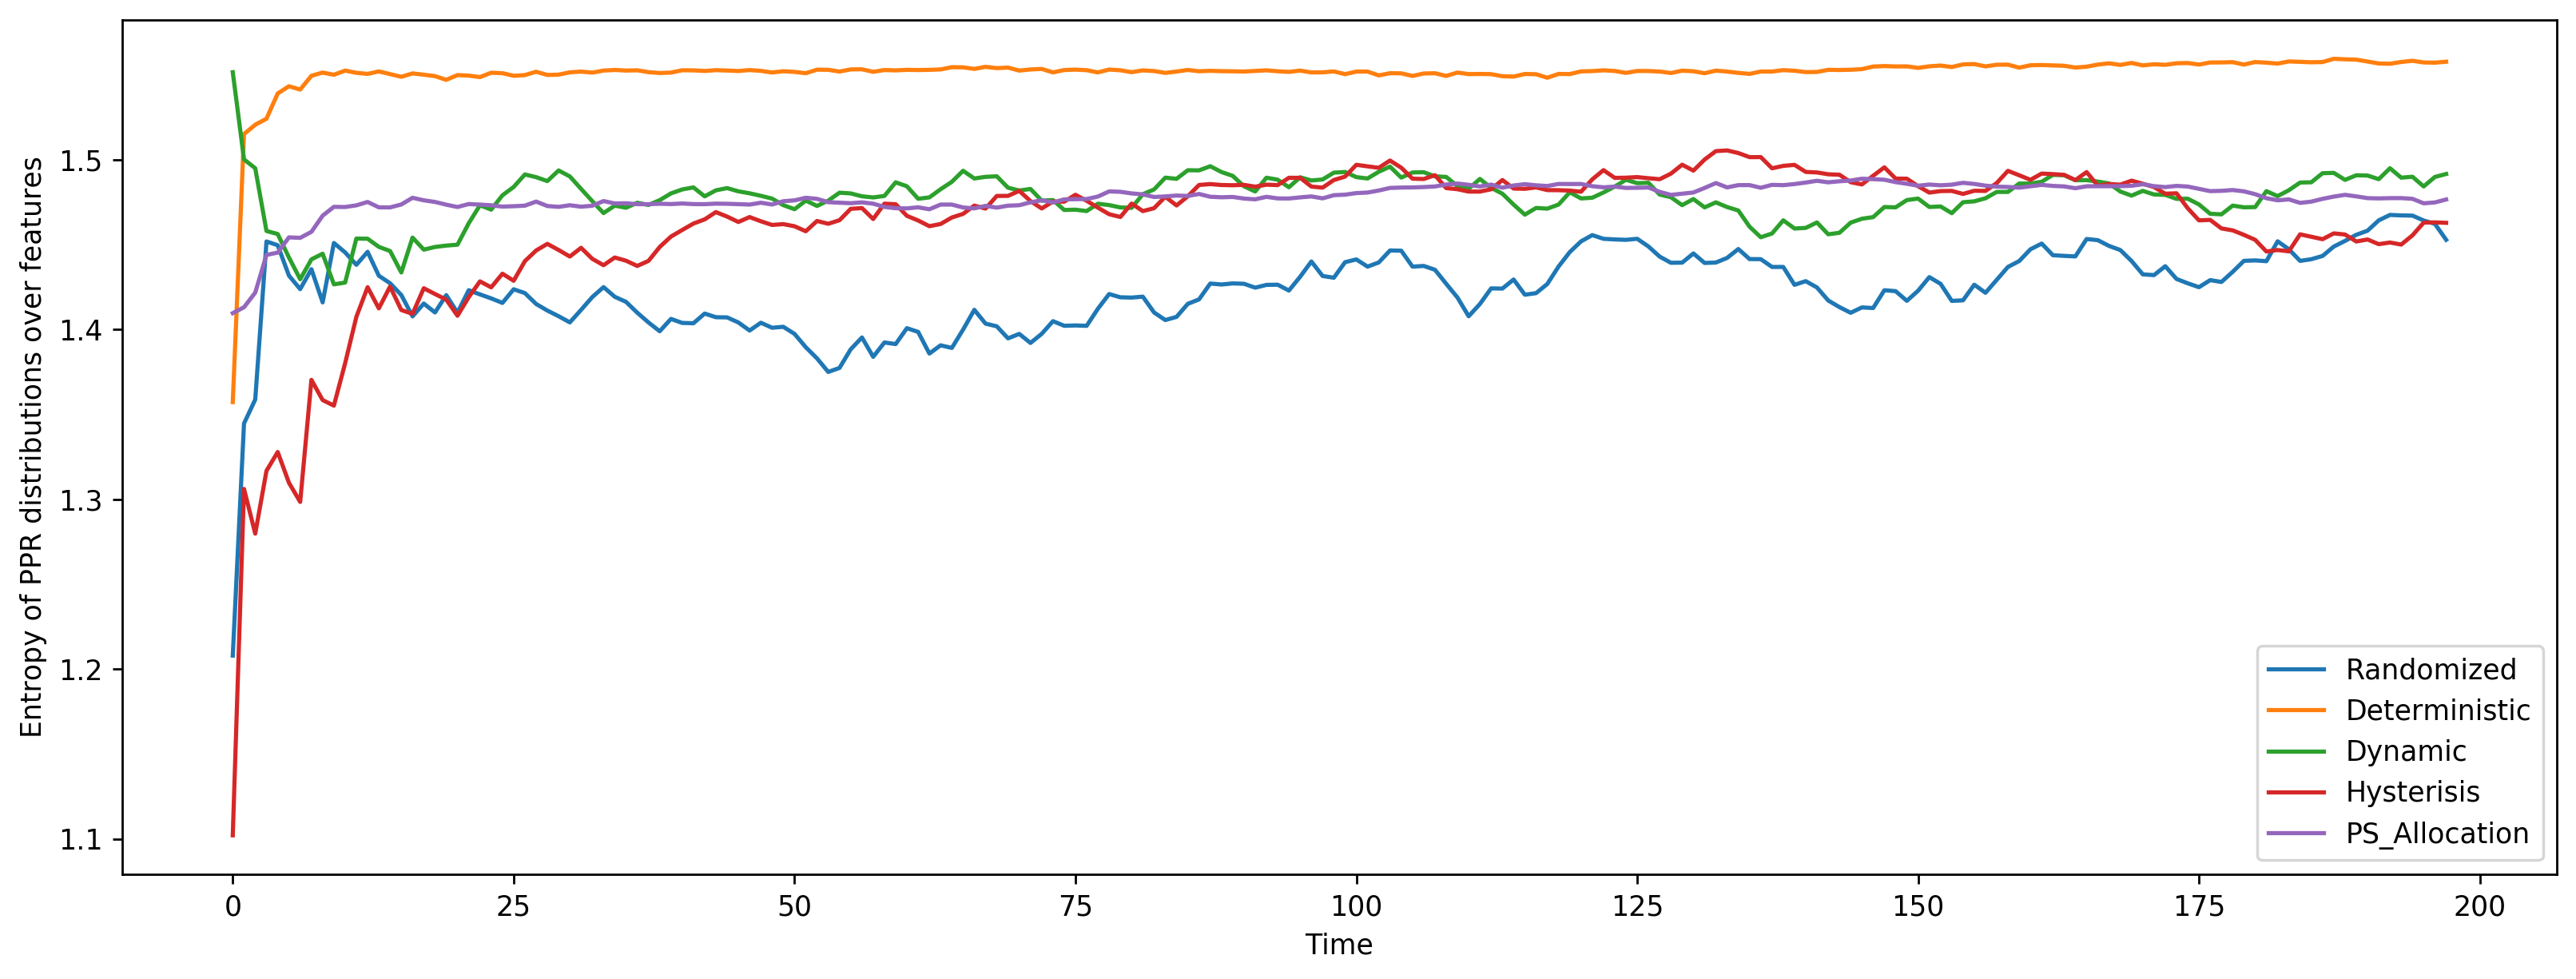

In [113]:
# new
from scipy.stats import entropy
def time_entropy(distr):
    t_ent = []
    for d in distr:
        t_ent.append(entropy(d))
    return t_ent

expo_ent_base = time_entropy(expo_ratios_base[1:])
expo_ent_rnd = time_entropy(expo_ratios_rnd[1:])
expo_ent_determine = time_entropy(expo_ratios_determine[1:])
expo_ent_dynm = time_entropy(expo_ratios_dynm[1:])
expo_ent_hyst = time_entropy(expo_ratios_hyst[1:])
expo_ent_psAlloc = time_entropy(expo_ratios_PSerialAloc[1:])


import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(13, 5))

# axes.plot(expo_ent_base, label='NMF')
axes.plot(expo_ent_rnd, label='Fixed Lottery')
axes.plot(expo_ent_determine, label='Deterministic')
axes.plot(expo_ent_dynm, label='Dynamic')
axes.plot(expo_ent_hyst, label='Sampling')
axes.plot(expo_ent_psAlloc, label='PS_Allocation')


axes.set_xlabel('Time')
axes.set_ylabel('Entropy of PPR distributions over features')
axes.legend(loc='best')
fig.set_dpi(250)
fig.tight_layout()


In [125]:
def cu_regret_indiv_dim(expo):
    expo = np.array(expo)
    regret = np.zeros(len(expo[0]))
    for t in range(len(expo)):
        regret += (1 - expo[t, :])
    return regret

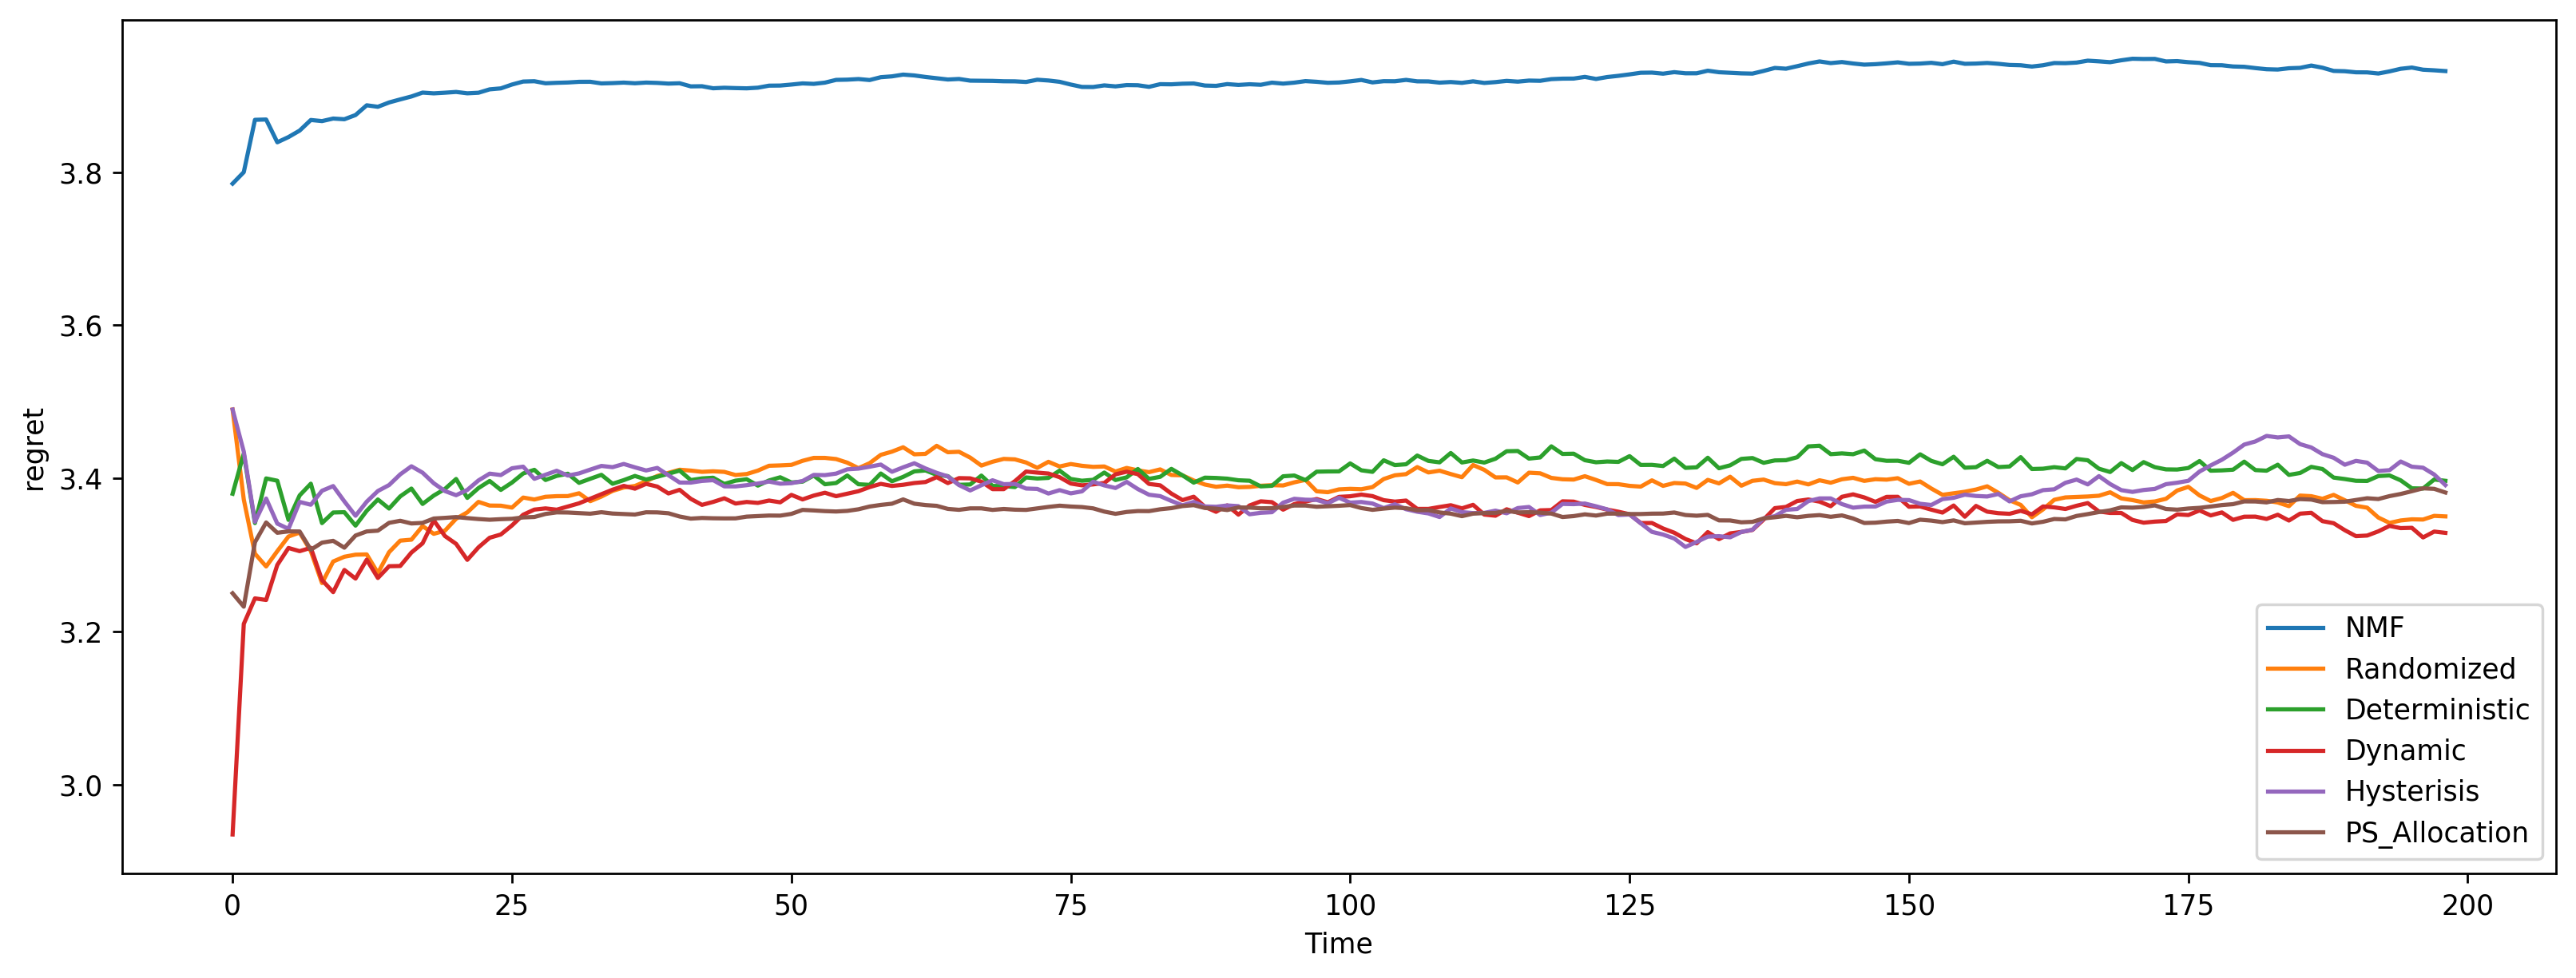

In [127]:
# new
from scipy.stats import entropy
def cu_regret_agg_dims(expos):
    cu_regs = []
    regret = 0
    for t in range(len(expos)):
        r = 0
        for d in range(len(feat_dict.keys())):
            r += (1 - expos[t][d])
        regret += r
        cu_regs.append(r)
    return cu_regs

until_t = max_time -1

expo_ent_base = cu_regret_agg_dims(expo_ratios_base[:until_t])
expo_ent_rnd = cu_regret_agg_dims(expo_ratios_rnd[:until_t])
expo_ent_determine = cu_regret_agg_dims(expo_ratios_determine[:until_t])
expo_ent_dynm = cu_regret_agg_dims(expo_ratios_dynm[:until_t])
expo_ent_hyst = cu_regret_agg_dims(expo_ratios_hyst[:until_t])
expo_ent_psAlloc = cu_regret_agg_dims(expo_ratios_PSerialAloc[:until_t])

import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(13, 5))

axes.plot(expo_ent_base, '-', label='NMF')
axes.plot(expo_ent_rnd, '-', label='Randomized')
axes.plot(expo_ent_determine, '-', label='Deterministic')
axes.plot(expo_ent_dynm, '-', label='Dynamic')
axes.plot(expo_ent_hyst, '-', label='Hysterisis')
axes.plot(expo_ent_psAlloc, '-', label='PS_Allocation')


axes.set_xlabel('Time')
axes.set_ylabel('regret')
axes.legend(loc='best')
fig.set_dpi(250)
fig.tight_layout()


In [117]:
expo_ent_rnd[:15]

[3.4899999999999998,
 3.3725,
 3.3016666666666667,
 3.285,
 3.305,
 3.3241666666666667,
 3.3292857142857146,
 3.3049999999999997,
 3.263333333333333,
 3.2914999999999996,
 3.297727272727273,
 3.3004166666666666,
 3.3007692307692307,
 3.2764285714285712,
 3.303666666666667]

In [146]:
np.sum(1-np.array(expo_ratios_determine)[:120, 1])

96.84111187568354

In [147]:
np.sum(1 - np.array(expo_ratios_rnd)[:, 0])

186.92202938288318

In [129]:
results = [ np.average(1 - np.array(expo_ratios_rnd)[:, :], axis=0),
            np.average(1 - np.array(expo_ratios_determine)[:, :], axis=0),
            np.average(1 - np.array(expo_ratios_dynm)[:, :], axis=0),
            np.average(1 - np.array(expo_ratios_hyst)[:, :], axis=0),
            np.average(1 - np.array(expo_ratios_PSerialAloc)[:, :], axis=0)]
results = np.array(results)
# df = pd.DataFrame(results, columns=feat_dict.keys(), index=['Fixed', 'Least Misery', 'Sampling', 'Allocation'])
df = pd.DataFrame(results, columns=feat_dict.keys(), index=['Fixed', 'Least Misery', 'Dynamic', 'Sampling', 'Allocation'])
df

,ACTIVITY,COUNTRY,GENDER,LOAN_BUCKET,PFR_BUCKET
Fixed,0.929610,0.823202,0.640071,0.597709,0.395165
Least Misery,0.768542,0.764391,0.704953,0.706637,0.461608
Dynamic,0.905962,0.773180,0.622759,0.613685,0.438265
Sampling,0.892071,0.833409,0.614984,0.605192,0.439015
Allocation,0.904045,0.789184,0.605695,0.614561,0.439987


In [130]:
print(np.average(1 - np.array(expo_ratios_base)[:, :]))
print(np.average(1 - np.array(expo_ratios_rnd)[:, :]))
print(np.average(1 - np.array(expo_ratios_determine)[:, :]))
print(np.average(1 - np.array(expo_ratios_dynm)[:, :]))
print(np.average(1 - np.array(expo_ratios_hyst)[:, :]))
print(np.average(1 - np.array(expo_ratios_PSerialAloc)[:, :]))

0.7839667158142878
0.6771513114480906
0.6812260950077174
0.6707704812514012
0.6769342323806817
0.6706942658508693


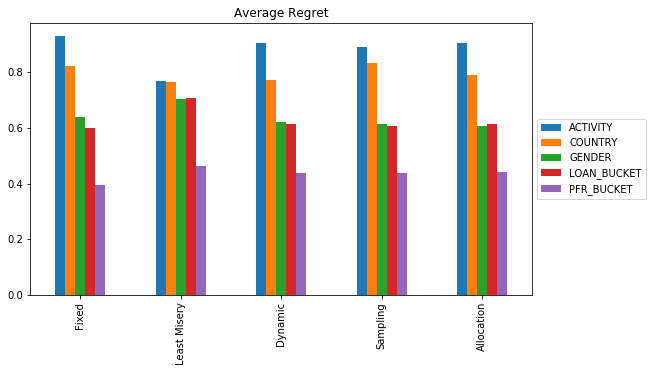

In [131]:
ax = df.plot.bar(figsize=(9, 5), legend=False, title='Average Regret')
plt.rcParams["figure.dpi"] = 240
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()
# plt.savefig('kiva_dim_regret_4methods.png', bbox_inches='tight', dpi=300)

In [159]:
# variance
print(np.var(np.sum(np.array(expo_ratios_base), axis=1)))
print(np.var(np.sum(np.array(expo_ratios_rnd), axis=1)))
print(np.var(np.sum(np.array(expo_ratios_determine), axis=1)))
print(np.var(np.sum(np.array(expo_ratios_dynm), axis=1)))
print(np.var(np.sum(np.array(expo_ratios_hyst), axis=1)))
print(np.var(np.sum(np.array(expo_ratios_PSerialAloc), axis=1)))
print()

# fairness
print(np.average(np.array(expo_ratios_base)[:, :]))
print(np.average(np.array(expo_ratios_rnd)[:, :]))
print(np.average(np.array(expo_ratios_determine)[:, :]))
print(np.average(np.array(expo_ratios_dynm)[:, :]))
print(np.average(np.array(expo_ratios_hyst)[:, :]))
print(np.average(np.array(expo_ratios_PSerialAloc)[:, :]))

0.000532577705193981
0.0007805917870915041
0.0020682958382747993
0.0024846876701027994
0.004221942298863589
0.0012423104643084356

0.21224136055750156
0.3269135085206909
0.3278821095928444
0.326983631621226
0.3310199834867247
0.33146667221094755


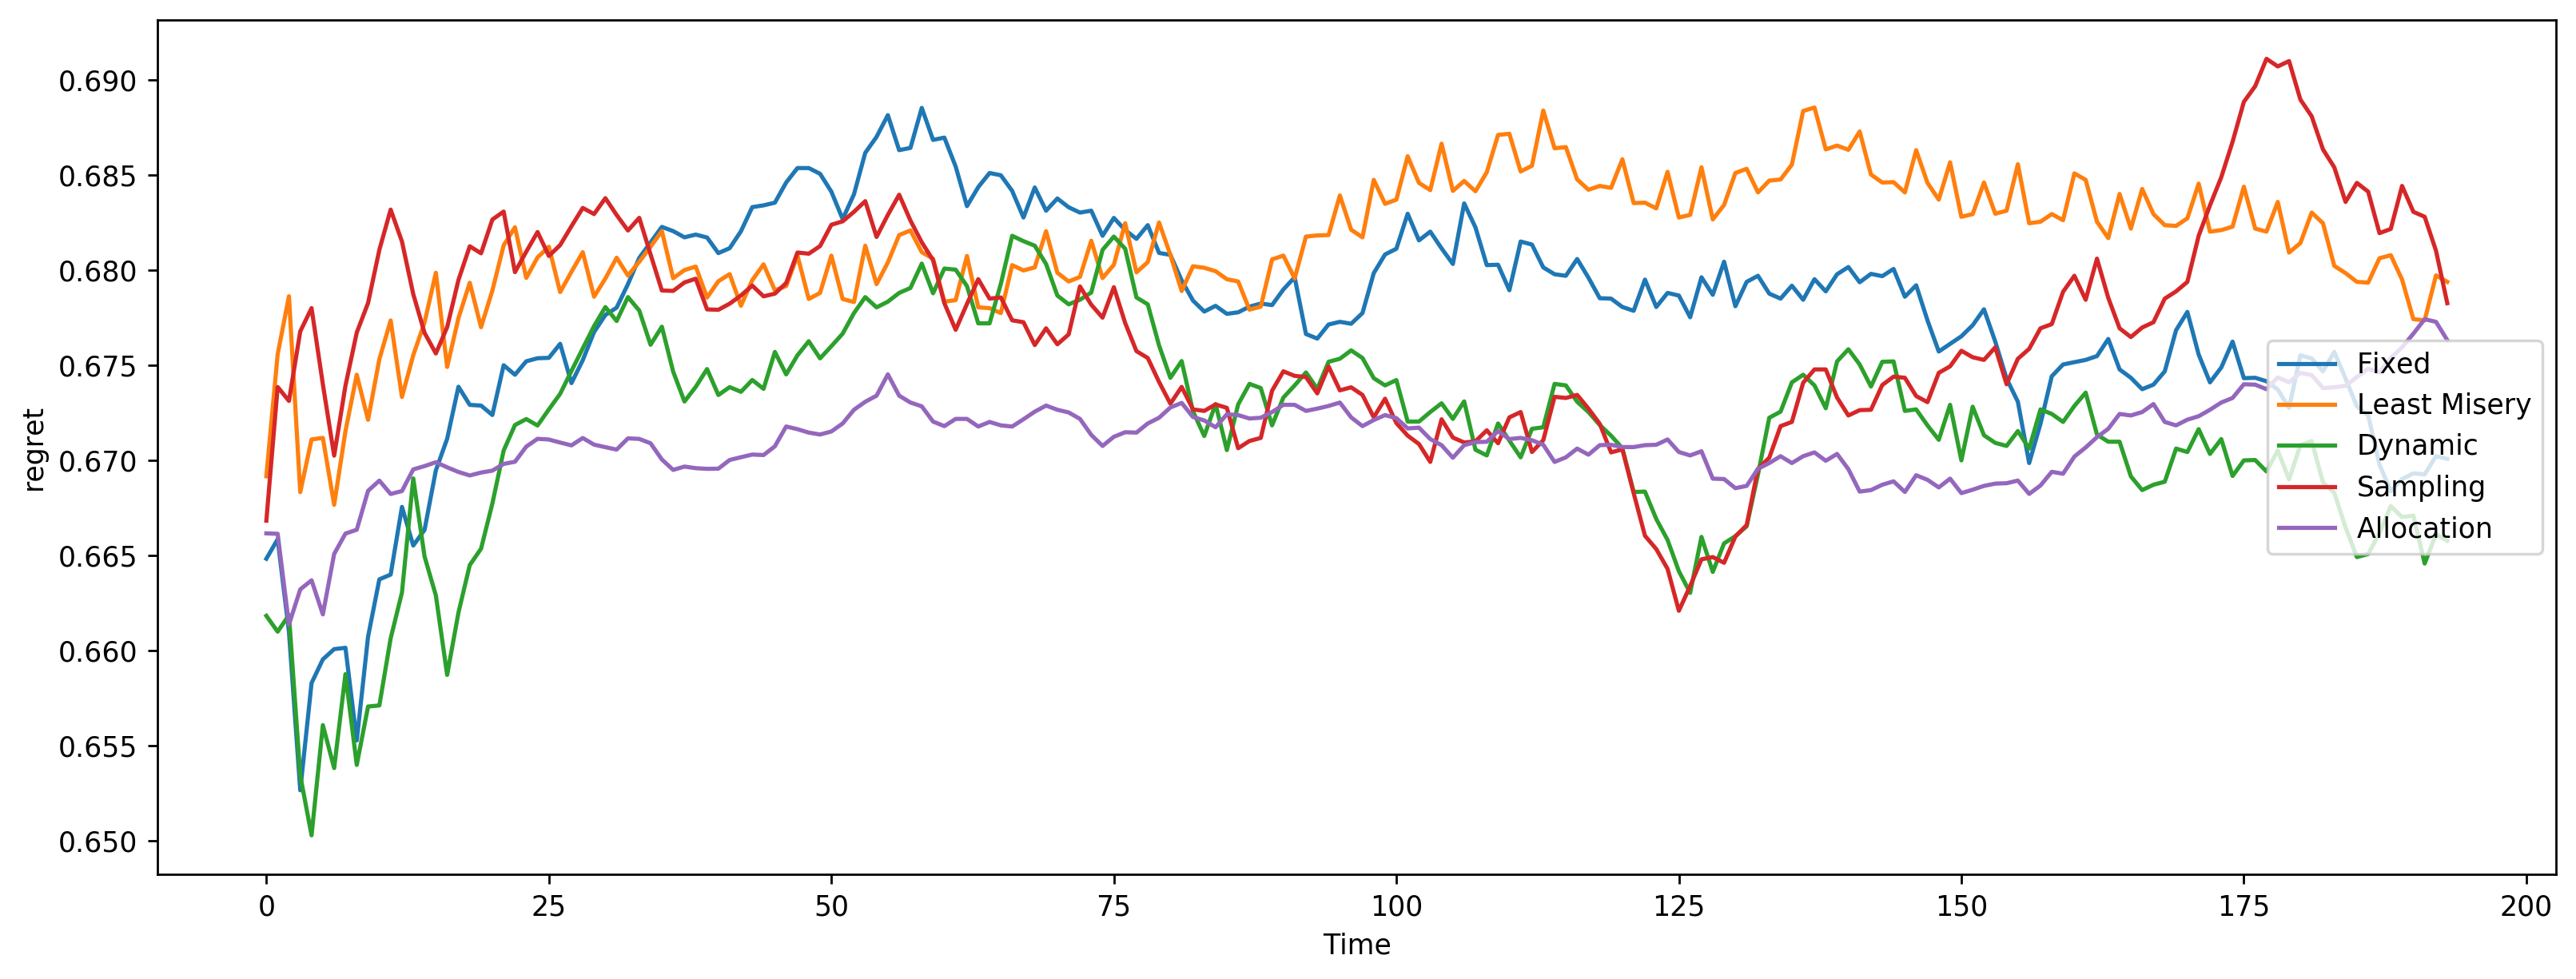

In [136]:
from scipy.stats import entropy
def cu_regret_agg_dims(expos):
    cu_regs = []
    regret = 0
    for t in range(len(expos)):
        r = 0
        for d in range(len(feat_dict.keys())):
            r += (1 - expos[t][d]) 
        r /= len(feat_dict.keys())
        cu_regs.append(r)
    return cu_regs

until_t = max_time - 1

expo_ent_base = cu_regret_agg_dims(expo_ratios_base[5:until_t])
expo_ent_rnd = cu_regret_agg_dims(expo_ratios_rnd[5:until_t])
expo_ent_determine = cu_regret_agg_dims(expo_ratios_determine[5:until_t])
expo_ent_hyst = cu_regret_agg_dims(expo_ratios_hyst[5:until_t])
expo_ent_dynm = cu_regret_agg_dims(expo_ratios_dynm[5:until_t])
expo_ent_psAlloc = cu_regret_agg_dims(expo_ratios_PSerialAloc[5:until_t])

import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(13, 5))

# axes.plot(expo_ent_base, '-', label='NMF')
axes.plot(expo_ent_rnd, '-', label='Fixed')
axes.plot(expo_ent_determine, '-', label='Least Misery')
axes.plot(expo_ent_dynm, '-', label='Dynamic')
axes.plot(expo_ent_hyst, '-', label='Sampling')
axes.plot(expo_ent_psAlloc, '-', label='Allocation')


axes.set_xlabel('Time')
axes.set_ylabel('regret')
axes.legend(loc='right')
fig.set_dpi(250)
fig.tight_layout()

In [135]:
fig.savefig('./RECSYS/SIGIR/kiva_avg_regret_overtime_oct20.png', bbox_inches='tight', dpi=300)

# Entropy-based aggregation

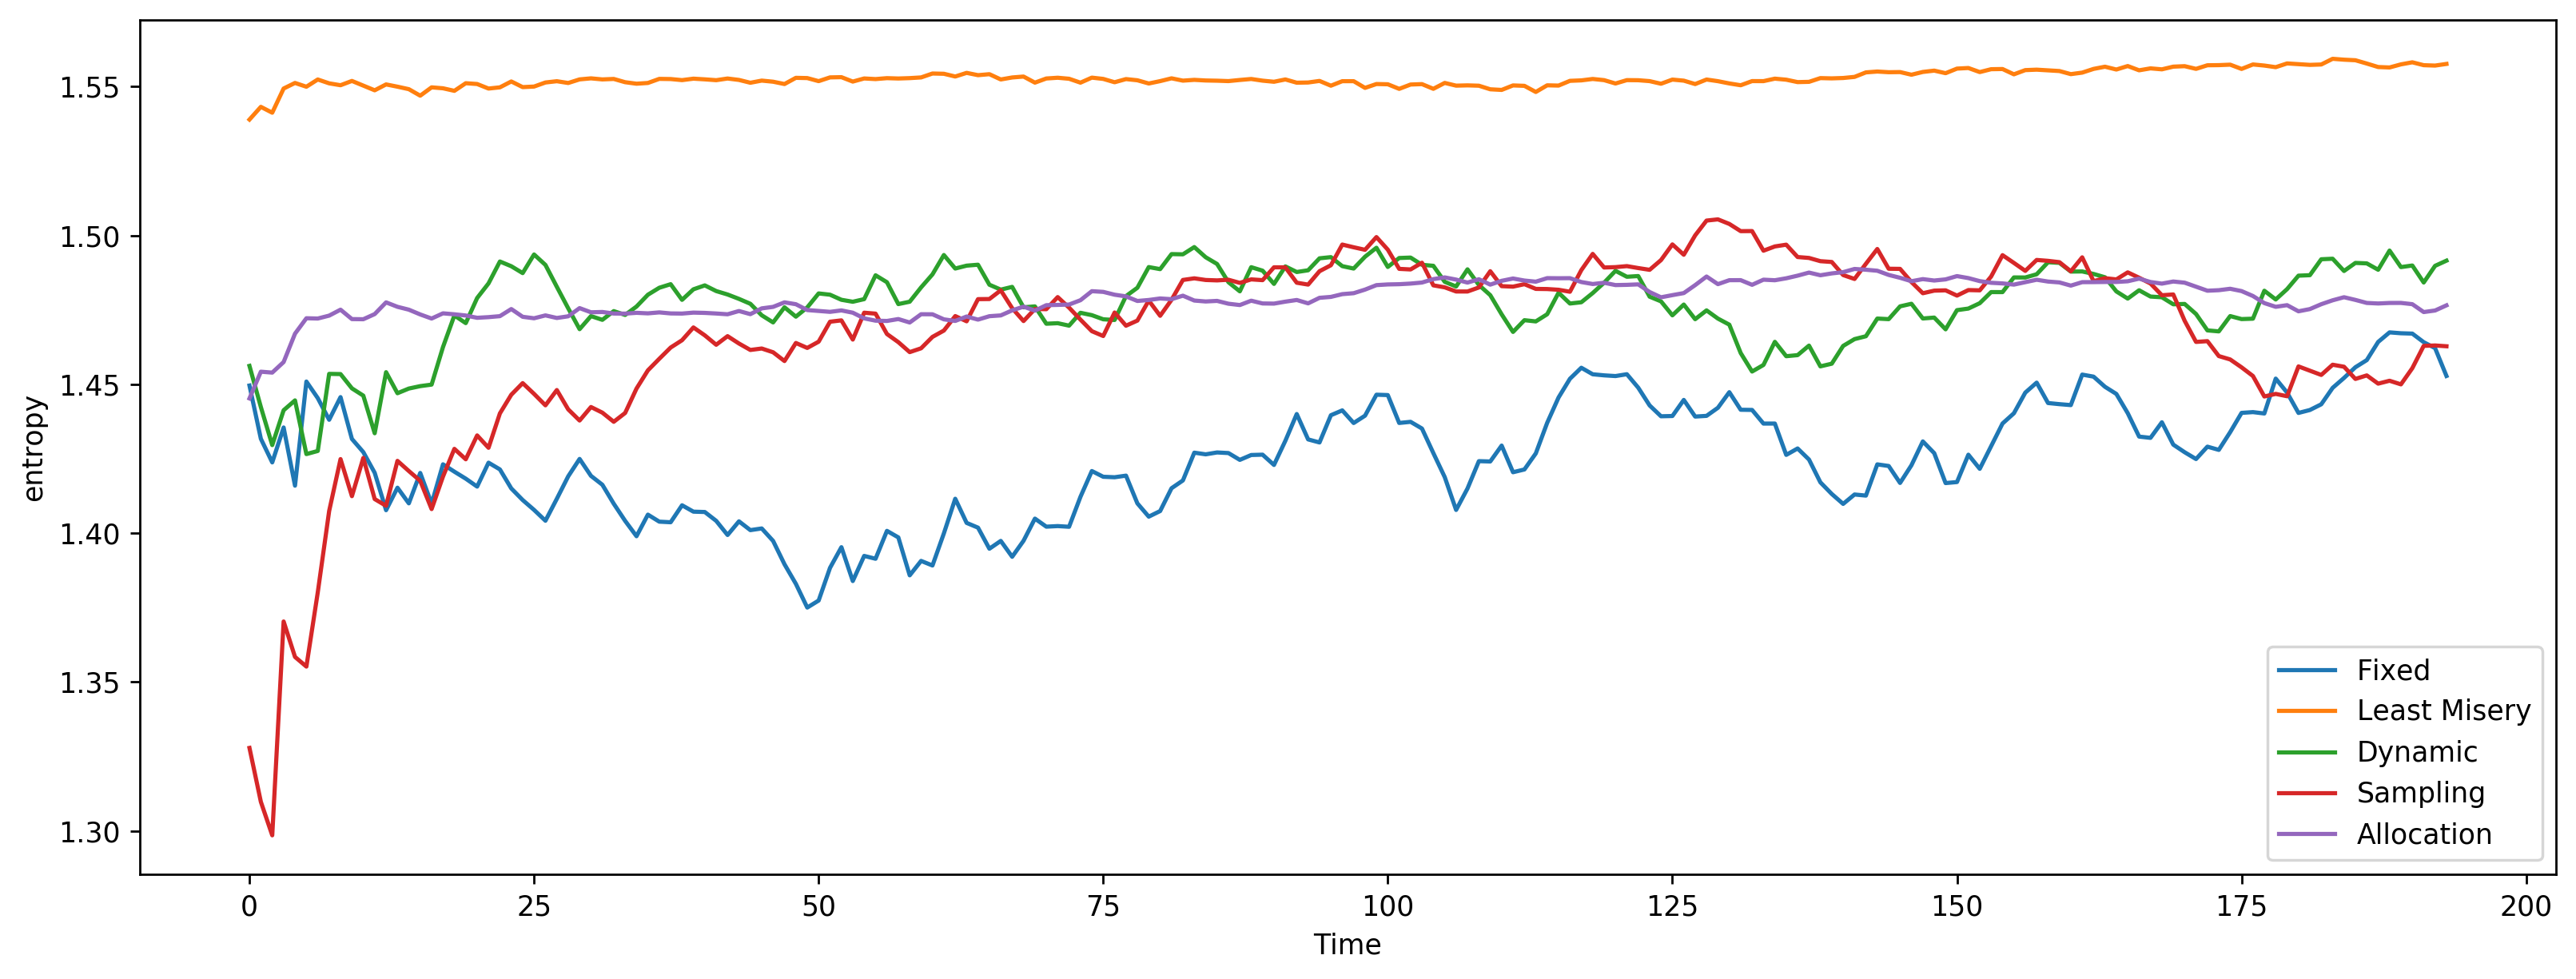

In [137]:
from scipy.stats import entropy

# entropy of each dimension aggregated over window
def cu_ent_dims(expos):
    cu_ents = []
    for t in range(len(expos)):
        # first, normalize the exposure values so that it sums to 1, then compute the entropy
        ent = entropy(np.array(expos[t])/np.sum(expos[t]))
        cu_ents.append(ent)
    return cu_ents

until_t = max_time - 1

expo_ent_base = cu_ent_dims(expo_ratios_base[5:until_t])
expo_ent_rnd = cu_ent_dims(expo_ratios_rnd[5:until_t])
expo_ent_determine = cu_ent_dims(expo_ratios_determine[5:until_t])
expo_ent_hyst = cu_ent_dims(expo_ratios_hyst[5:until_t])
expo_ent_dynm = cu_ent_dims(expo_ratios_dynm[5:until_t])
expo_ent_psAlloc = cu_ent_dims(expo_ratios_PSerialAloc[5:until_t])

import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(13, 5))

# axes.plot(expo_ent_base, '-', label='NMF')
axes.plot(expo_ent_rnd, '-', label='Fixed')
axes.plot(expo_ent_determine, '-', label='Least Misery')
axes.plot(expo_ent_dynm, '-', label='Dynamic')
axes.plot(expo_ent_hyst, '-', label='Sampling')
axes.plot(expo_ent_psAlloc, '-', label='Allocation')


axes.set_xlabel('Time')
axes.set_ylabel('entropy')
axes.legend(loc='best')
fig.set_dpi(250)
fig.tight_layout()

In [286]:
np.array(expo_ratios_determine[5:20])

array([[0.0075    , 0.28416667, 0.46166667, 0.385     , 0.60666667],
       [0.00857143, 0.25928571, 0.52071429, 0.37642857, 0.58714286],
       [0.0075    , 0.30625   , 0.49375   , 0.368125  , 0.59625   ],
       [0.00722222, 0.28      , 0.53555556, 0.36222222, 0.57944444],
       [0.0485    , 0.2565    , 0.51      , 0.3525    , 0.5775    ],
       [0.07636364, 0.23363636, 0.48454545, 0.35363636, 0.57909091],
       [0.07041667, 0.21541667, 0.45458333, 0.34041667, 0.60958333],
       [0.065     , 0.25115385, 0.44769231, 0.33692308, 0.61      ],
       [0.06035714, 0.28642857, 0.44821429, 0.33392857, 0.61      ],
       [0.05633333, 0.26966667, 0.43466667, 0.368     , 0.59433333],
       [0.0534375 , 0.26      , 0.460625  , 0.3675    , 0.5859375 ],
       [0.05029412, 0.28441176, 0.45205882, 0.36411765, 0.58647059],
       [0.04805556, 0.27472222, 0.47611111, 0.36027778, 0.58083333],
       [0.04578947, 0.29736842, 0.47447368, 0.35631579, 0.58078947],
       [0.061     , 0.283     , 0.

In [287]:
np.array(expo_ratios_PSerialAloc[5:20])

array([[0.0975    , 0.26916667, 0.32333333, 0.40083333, 0.575     ],
       [0.095     , 0.26928571, 0.32      , 0.40428571, 0.57428571],
       [0.095     , 0.259375  , 0.325625  , 0.406875  , 0.5725    ],
       [0.09666667, 0.25777778, 0.32      , 0.40777778, 0.56888889],
       [0.0965    , 0.2565    , 0.331     , 0.405     , 0.57      ],
       [0.09590909, 0.24863636, 0.32636364, 0.40590909, 0.57863636],
       [0.09416667, 0.25208333, 0.32291667, 0.40083333, 0.5875    ],
       [0.09461538, 0.24692308, 0.32269231, 0.39884615, 0.58961538],
       [0.09      , 0.24464286, 0.33035714, 0.39964286, 0.58964286],
       [0.089     , 0.23533333, 0.334     , 0.404     , 0.585     ],
       [0.089375  , 0.2353125 , 0.331875  , 0.4059375 , 0.579375  ],
       [0.08941176, 0.23264706, 0.335     , 0.40852941, 0.575     ],
       [0.09083333, 0.23083333, 0.33861111, 0.40472222, 0.57666667],
       [0.08815789, 0.23236842, 0.34289474, 0.40605263, 0.57473684],
       [0.085     , 0.23375   , 0.

In [178]:
import scipy.stats as stats

Text(0.5, 0, 'regret')

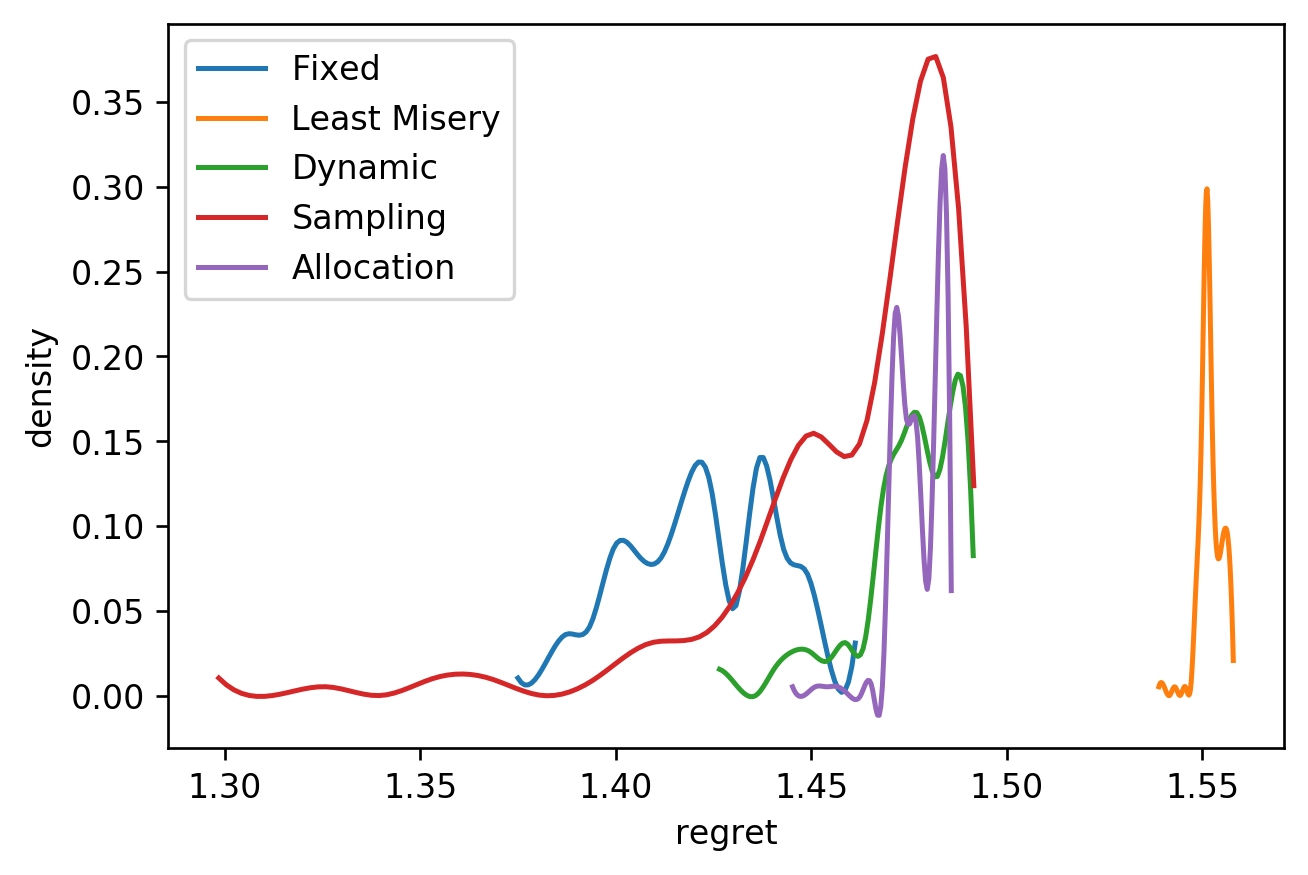

In [140]:
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

def smooth_plot_data(d):
    h = np.histogram(d, bins=15)
    T = h[1][:-1]
    y = h[0]/np.sum(h[0])
    xnew = np.linspace(T.min(), T.max(), 100)
    spl = make_interp_spline(T, y, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    return xnew, power_smooth

# d_base = smooth_plot_data(expo_ent_base)
d_rnd = smooth_plot_data(expo_ent_rnd)
d_determine = smooth_plot_data(expo_ent_determine)
d_dynm = smooth_plot_data(expo_ent_dynm)
d_hyst = smooth_plot_data(expo_ent_hyst)
d_psAlloc = smooth_plot_data(expo_ent_psAlloc)


# plt.plot(d_base[0], d_base[1], label='Baseline')
plt.plot(d_rnd[0], d_rnd[1], label='Fixed')
plt.plot(d_determine[0], d_determine[1], label='Least Misery')
plt.plot(d_dynm[0], d_dynm[1], label='Dynamic')
plt.plot(d_hyst[0], d_hyst[1], label='Sampling')
plt.plot(d_psAlloc[0], d_psAlloc[1], label='Allocation')
plt.legend(loc="best")
plt.ylabel('density')
plt.xlabel('regret')
# plt.show()

# plt.savefig('./kiva_regret_variance_sep20.png', dpi=300)